In [1]:
import torch 
import os
import sys
os.chdir('/home/baly/projects/sopt_shape')
from lib.library import *
from lib.lib_ot import *
from lib.sliced_opt import *
from lib.lib_shape import *
from lib.cpd import *
from lib.icp_ffd import *
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/home/baly/projects/sopt_shape/lib/sliced_opt.py:79: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  X_theta=np.dot(theta,X.T)


init
results/3D_neutral_2_29_0.05/


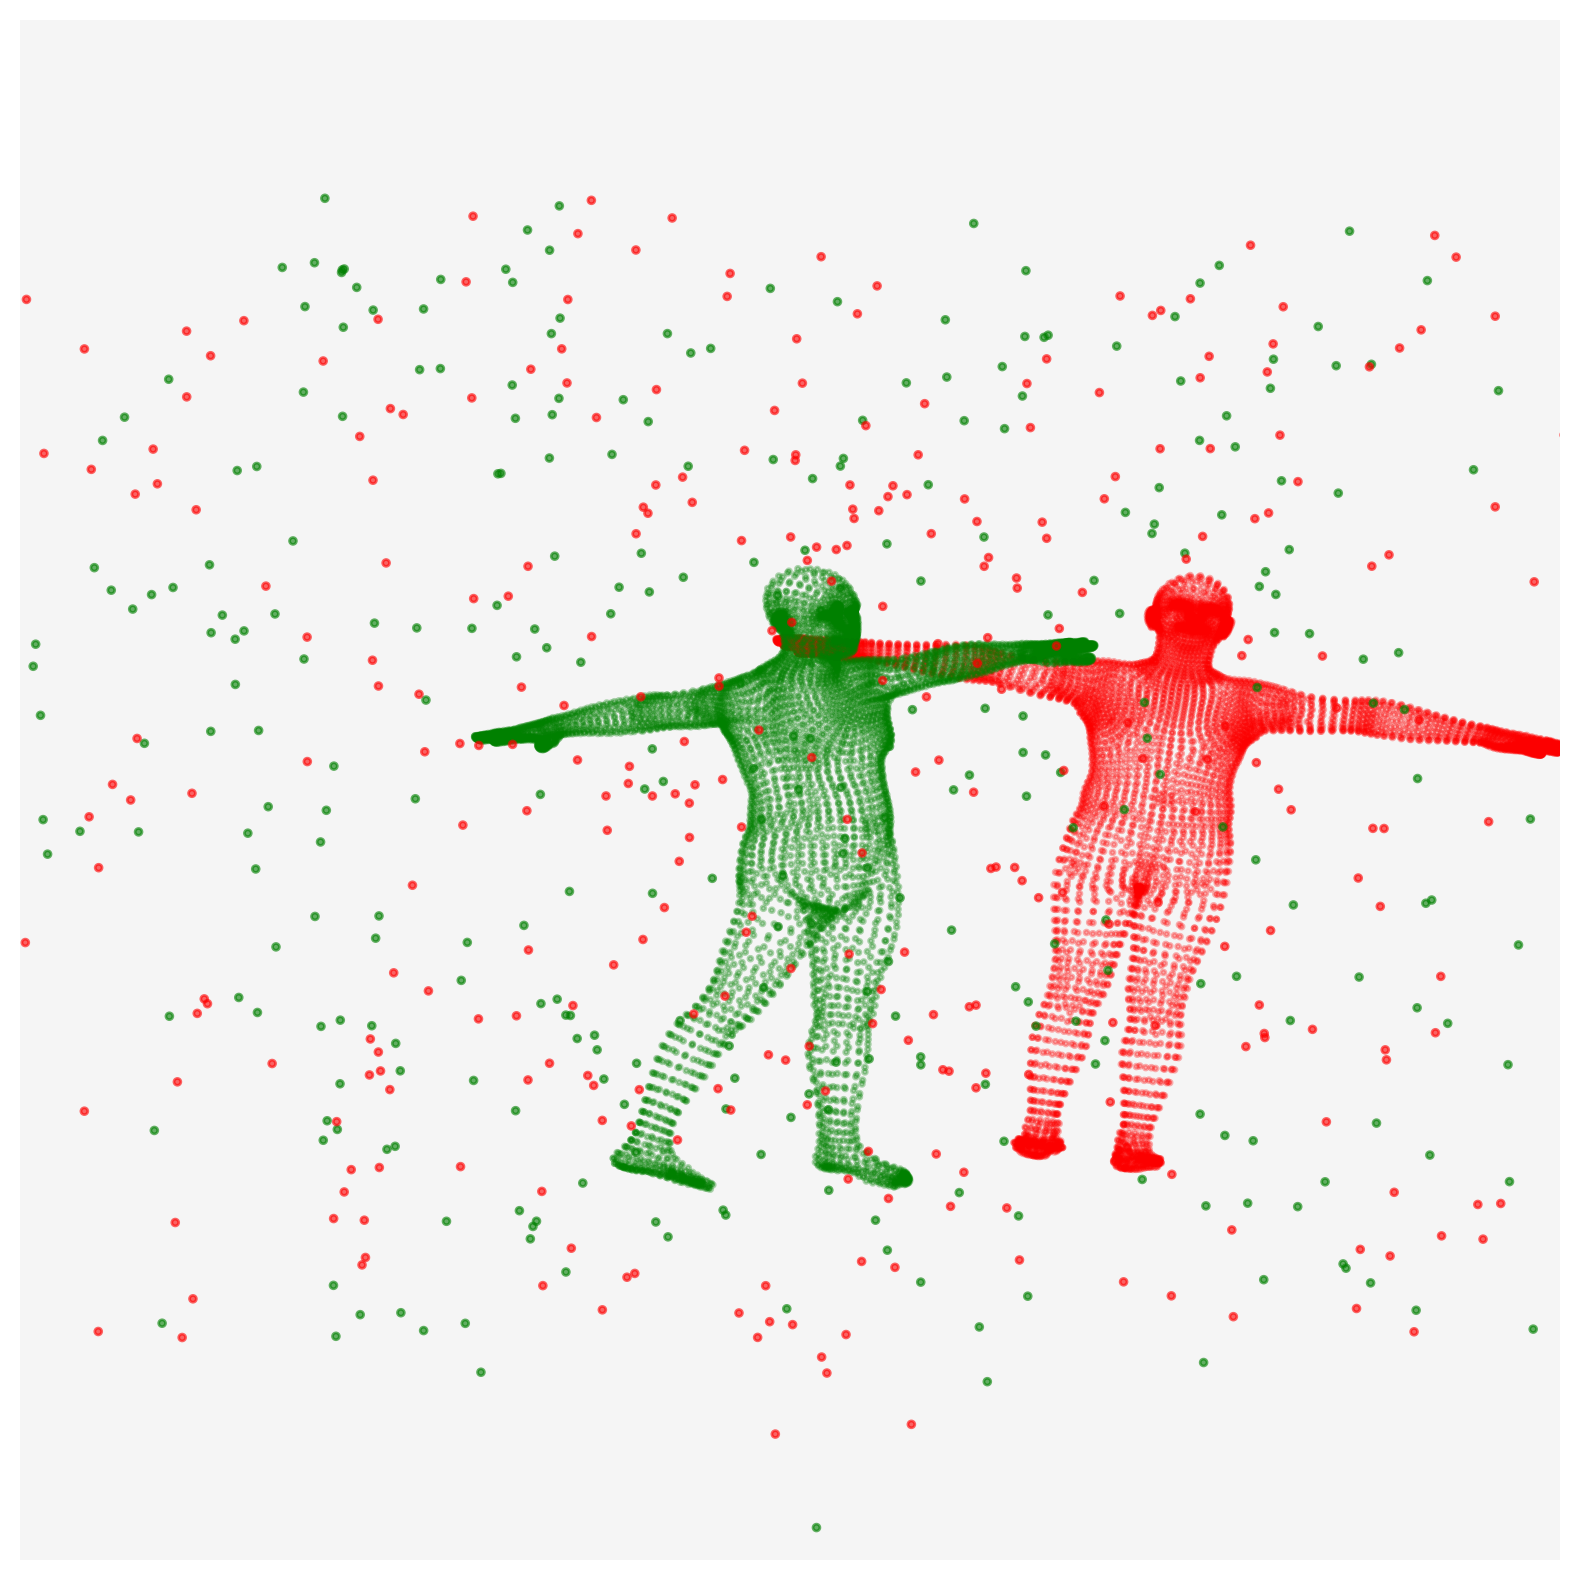

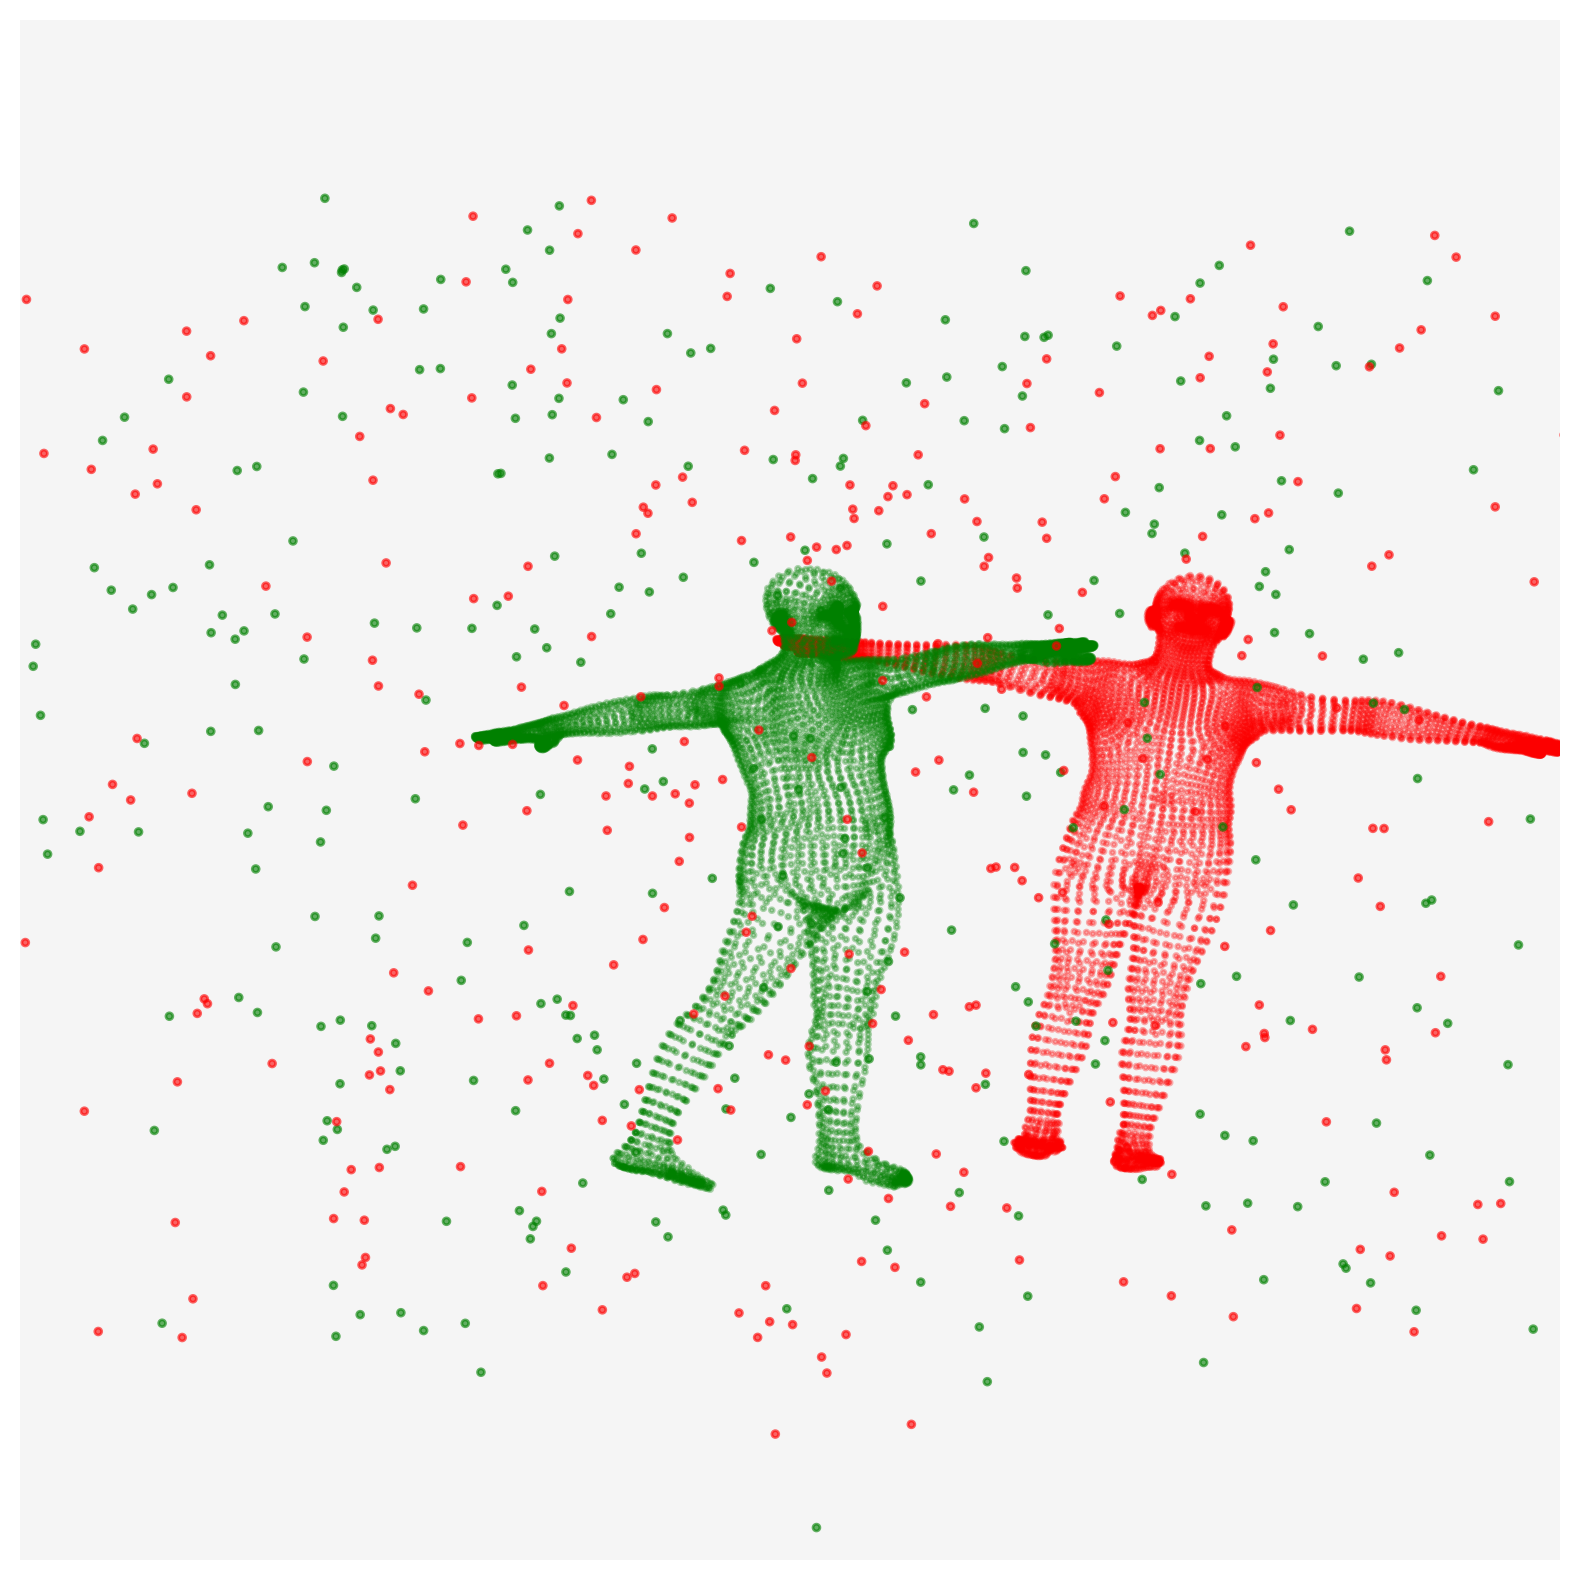

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
init
results/3D_neutral_2_29_0.10/


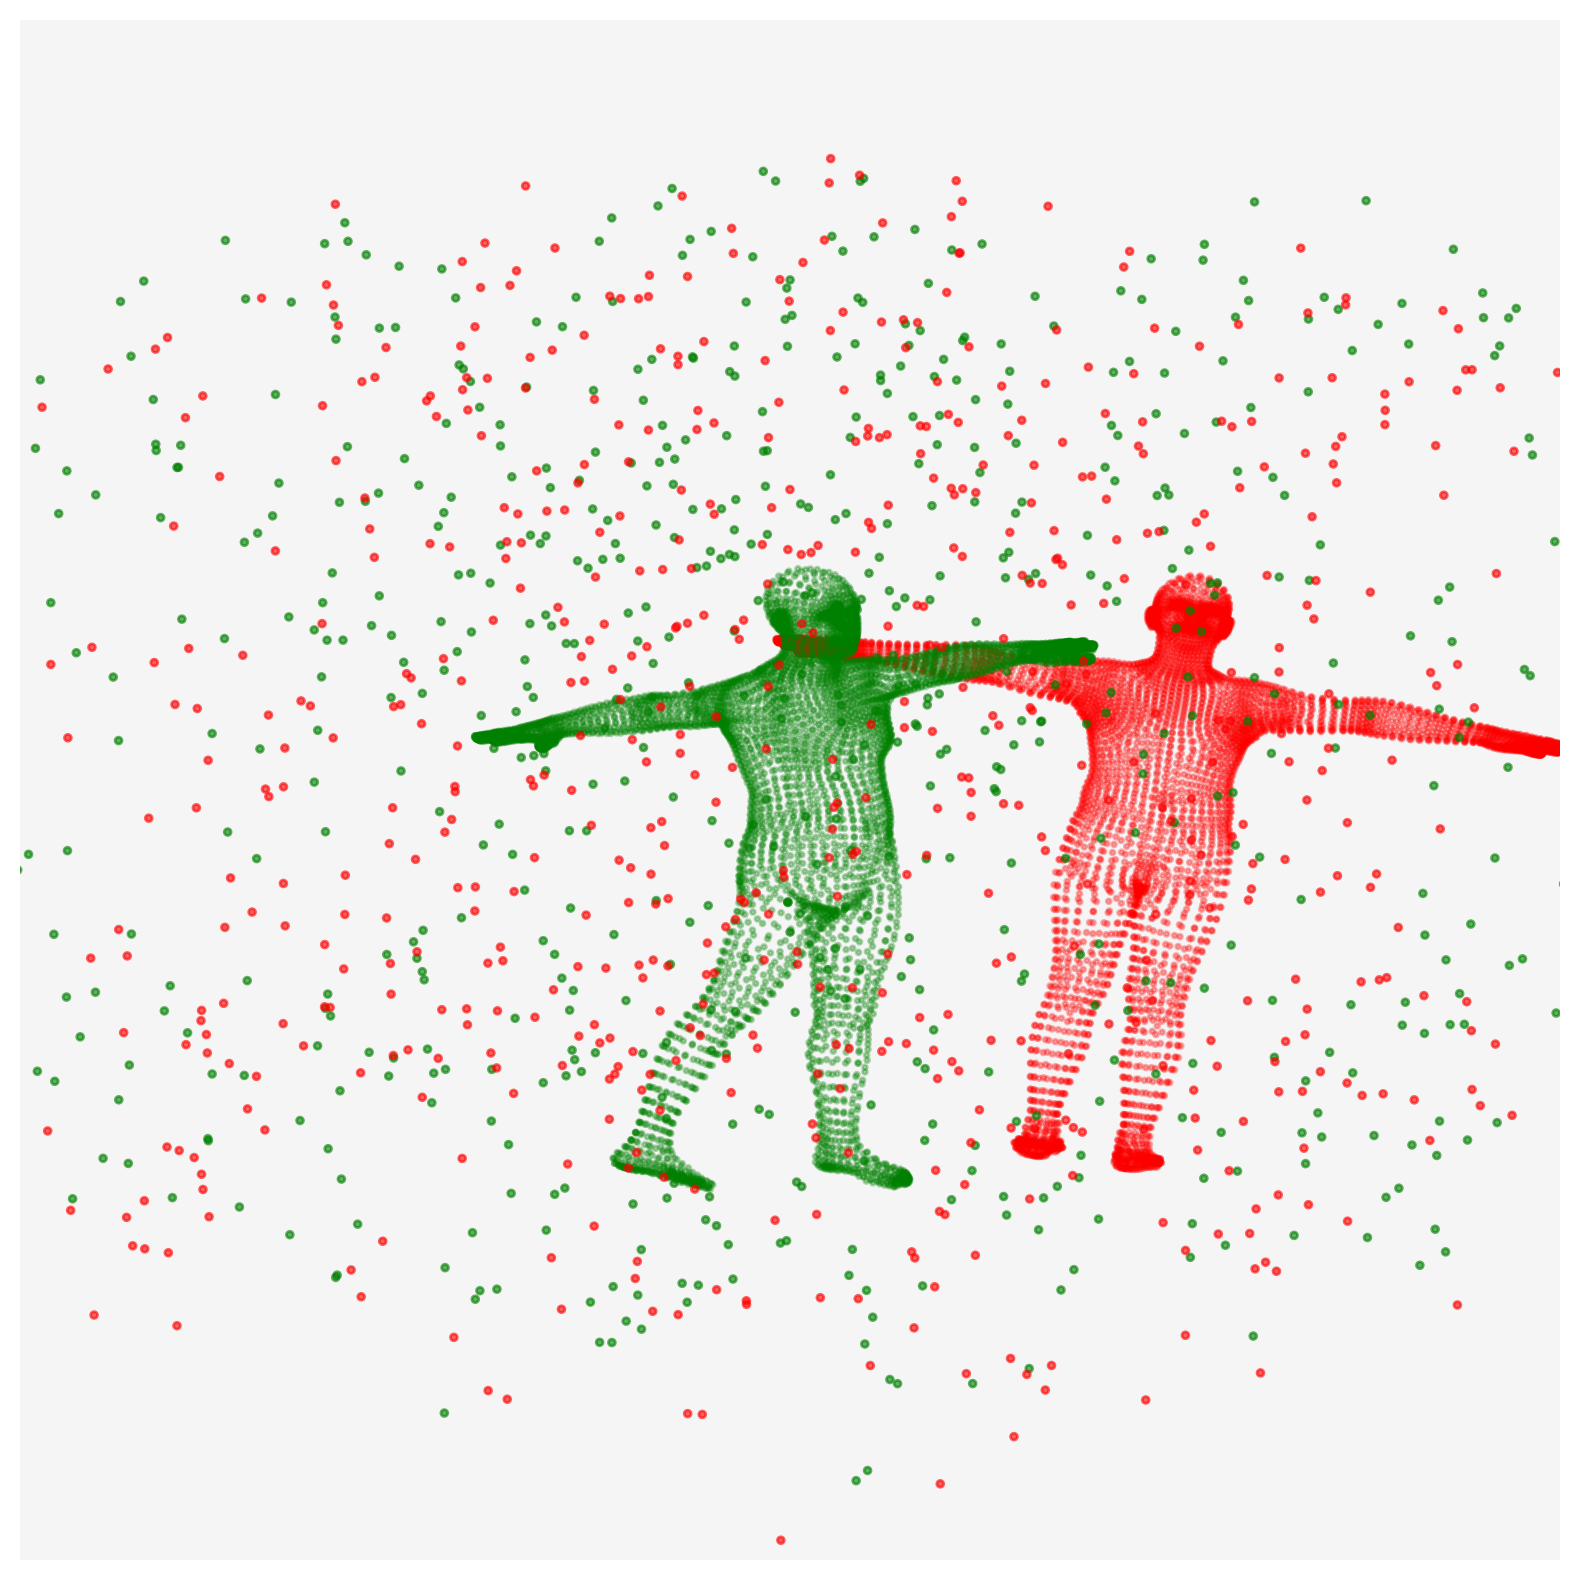

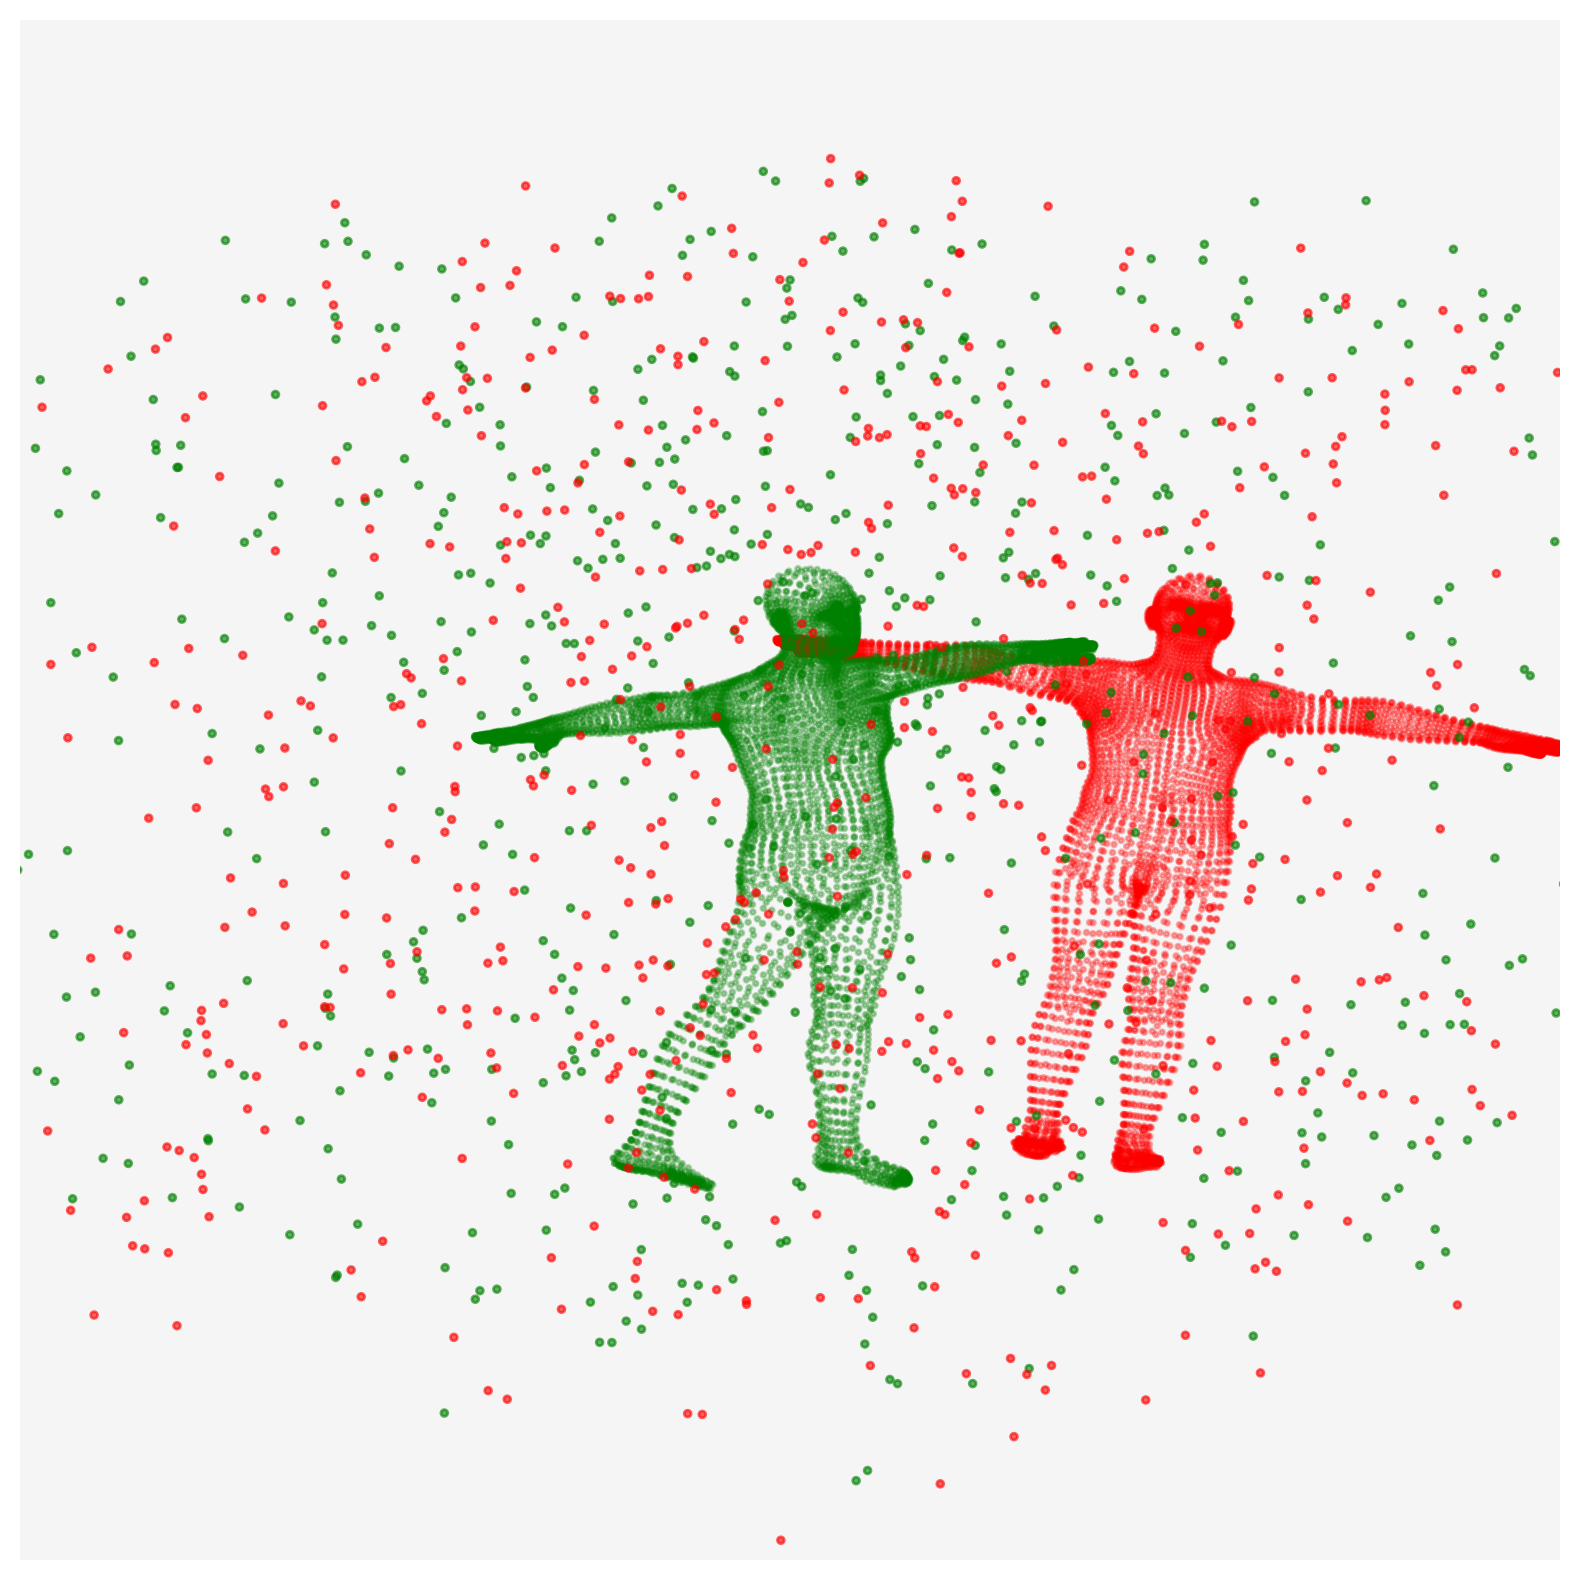

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
CPD
results/3D_neutral_2_29_0.05/


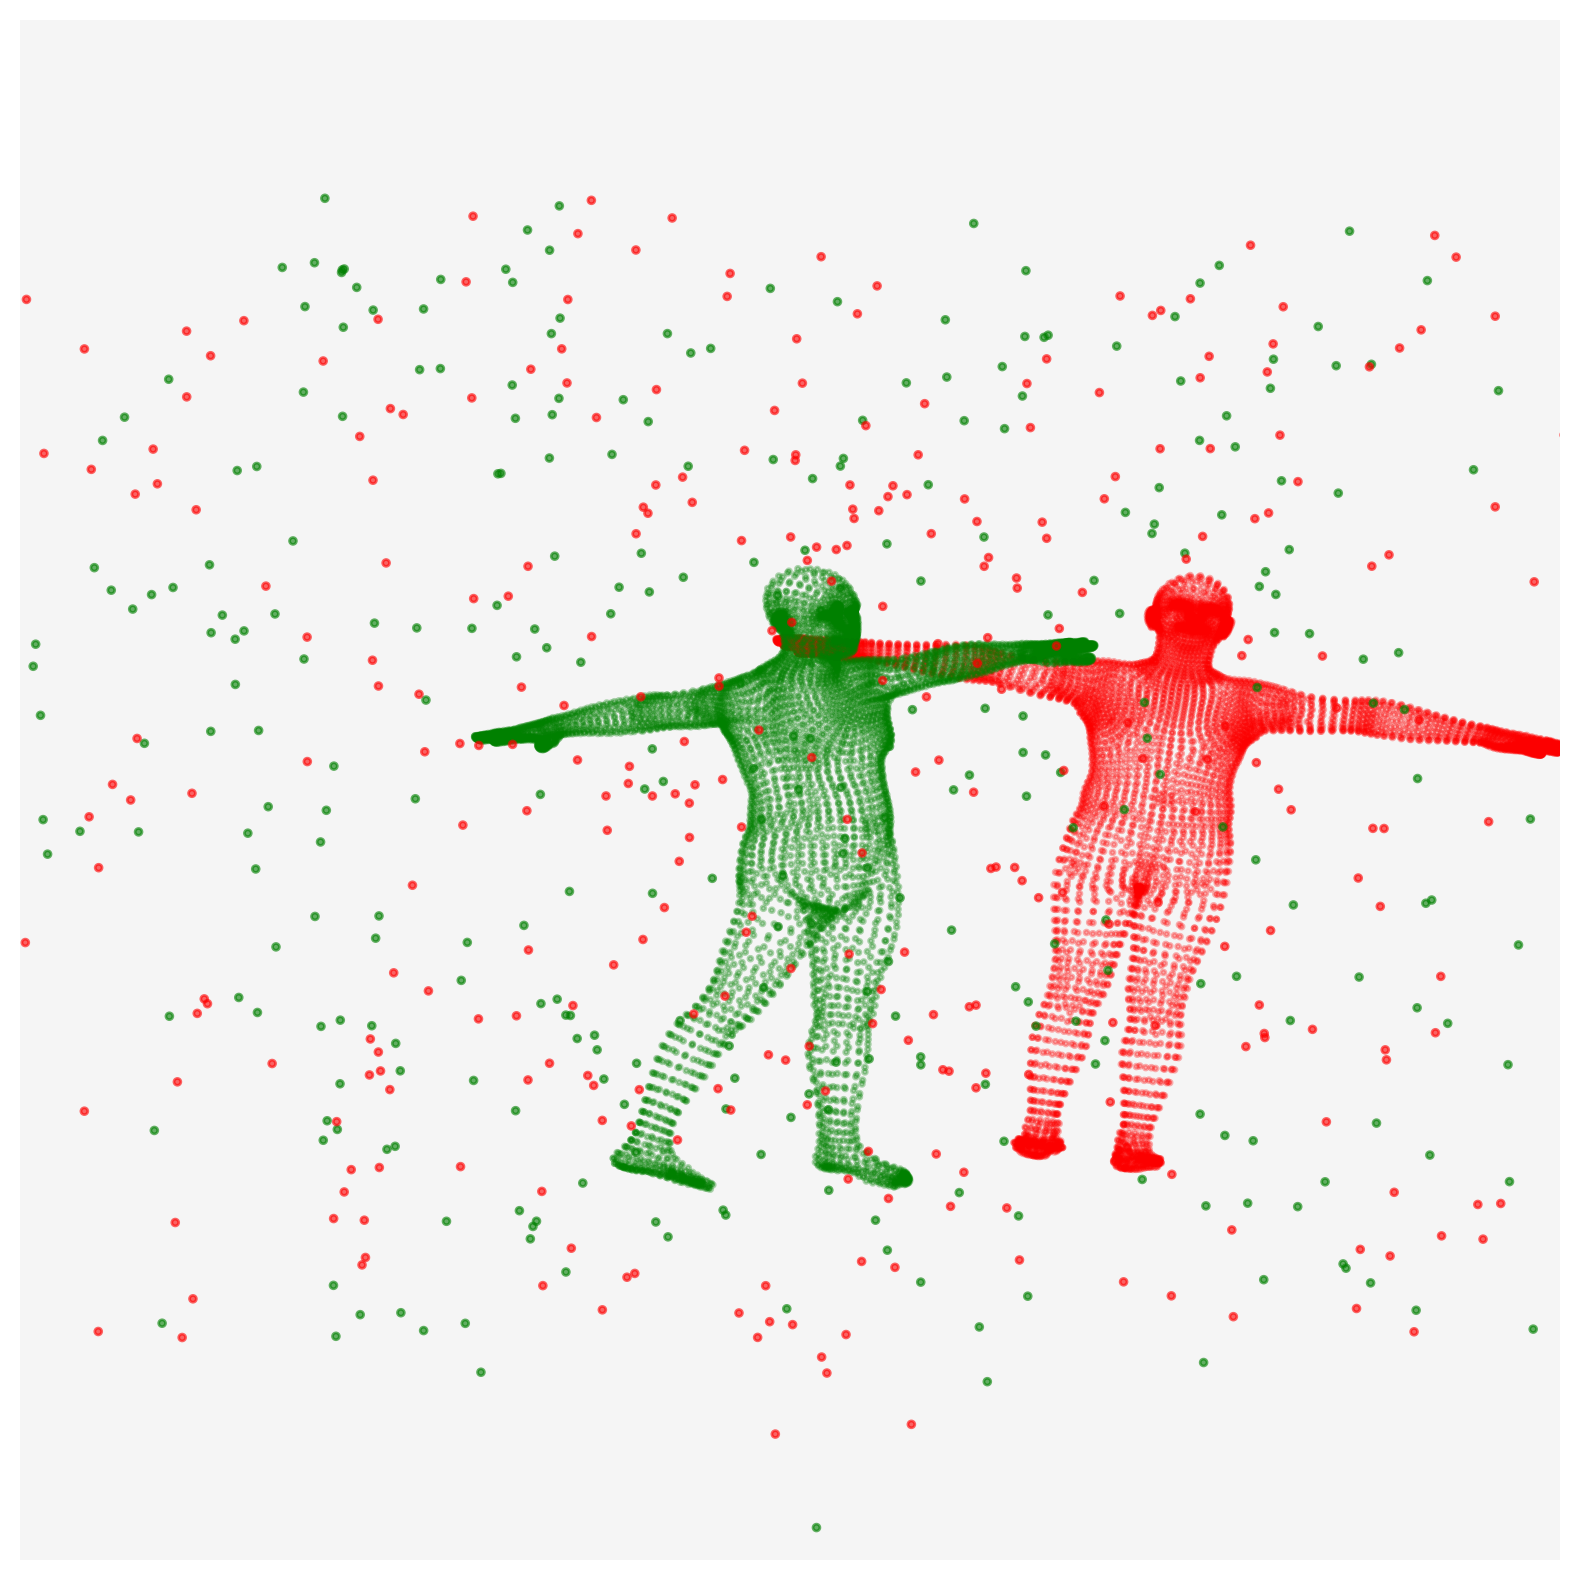

record_idx is [ 0  5 10 15 20 26 31 36 41 46 52 57 62 67 72 78 83 88 93 99]
time is  562.404212474823
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
CPD
results/3D_neutral_2_29_0.10/


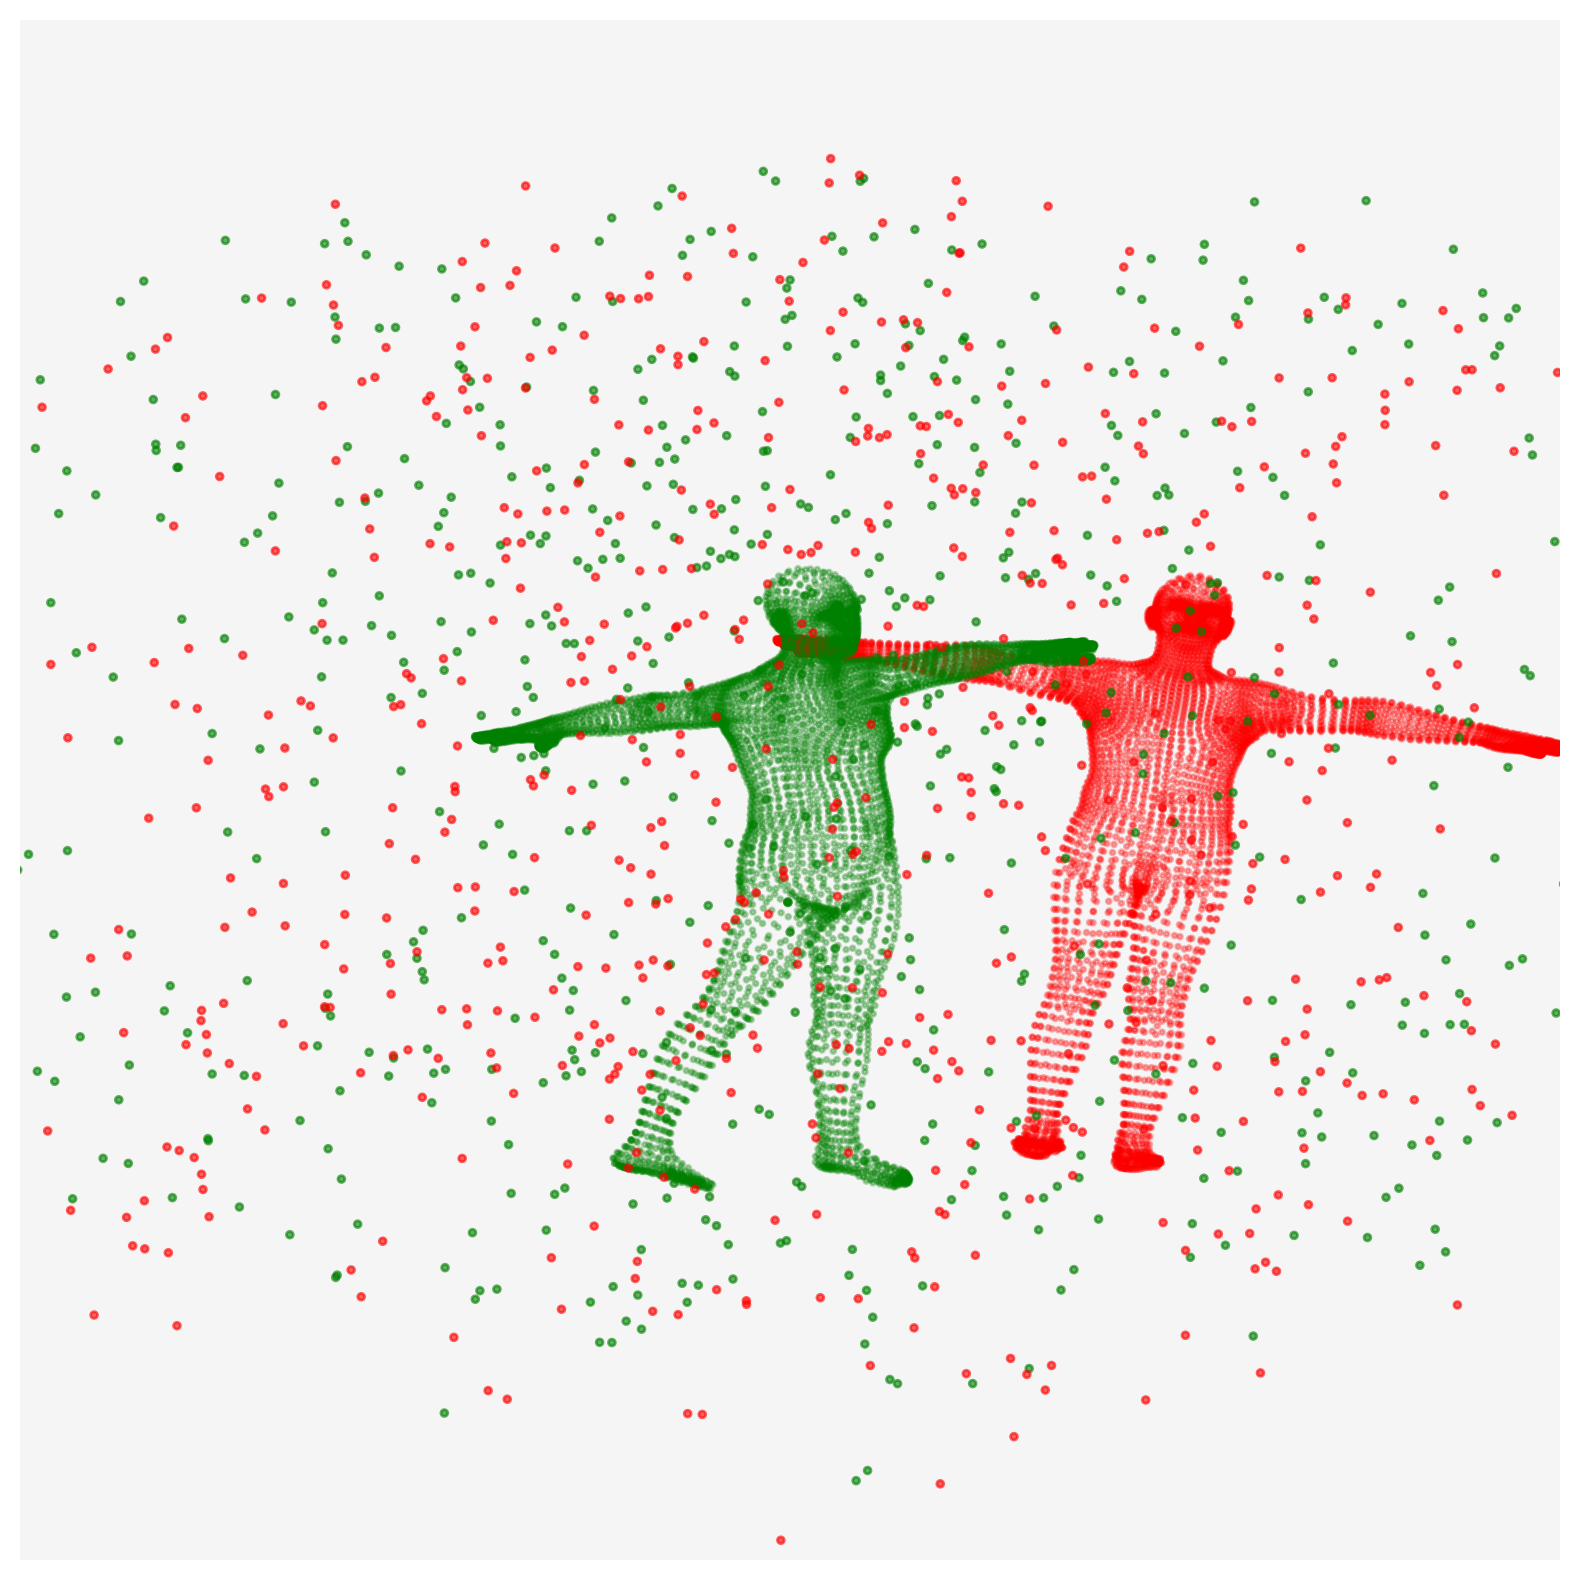

In [ ]:
# load data 
label='neutral_2_29'
data=torch.load('data/%s.pt'%(label))
eta_list=[0.05,0.10]
device='cuda:1'

method_list=[
    'init',
  'CPD',
'OT-RBF',
'OT-TPS', 
'SOT-RBF',
'SOT-TPS',
 'TPS-RPM',
 'TPS-RPM-new',
 'OPT-RBF',
 'OPT-TPS',
  'SOPT-RBF',
  'SOPT-TPS'
]
for method in method_list[0:]:
    for eta in eta_list:
        print(method)
        data=torch.load('data/%s.pt'%(label))
        save_path='results/3D_%s_%0.2f/'%(label,eta)
        print(save_path)
        X0=data['X0']
        N0=X0.shape[0]
        X=data['X'+str(eta)]
        Y=data['Y'+str(eta)]
        make_plot(X,Y,N0)
        device='cuda:1'
        sigma2,eps=0.05,1.0
    
        Lambda=2*np.sum((X[0:N0].mean(0)-Y[0:N0].mean(0))**2)
    
        corr_ot={'name':'ot'}
        corr_opt={'name':'opt','N0':N0}
        corr_sot={'name':'sot','n_proj':100}
        corr_sopt={'name':'sopt','N0':N0+20,'n_proj':100}
        corr_sinkhorn={'name':'sinkhorn','reg':0.1*Y.var(),'N0':N0,'Lambda':Lambda}
        corr_sinkhorn_pr={'name':'sinkhorn_pr','reg':0.01*Y.var(),'N0':N0}
        kernel_gaussian={'name':'gaussian','C':X.copy(),'param':sigma2,'eps':1.0}
        kernel_tps={'name':'tps','C':X.copy(),'param':2,'eps':1.0}

        if method == 'init':
            make_plot(X,Y,N0,'%s/pic/%s.jpg'%(save_path,method))
        elif method == 'CPD':
            start_time=time.time()
            model,Yhat_list,record_idx=CPD(X, Y , n_iter_max=100, n_iter_rigid=10)
            end_time=time.time()
        else:
            # choose corr parameters 
            if 'OT' in method and 'SOT' not in method:
                corr=corr_ot
            elif 'SOT' in method:
                corr=corr_sot
            elif 'OPT' in method and 'SOPT' not in method:
                corr=corr_opt
            elif 'SOPT' in method:
                corr=corr_sopt
            elif 'RPM' in method and 'new' not in method:
                corr=corr_sinkhorn
            elif 'RPM(new)' in method:
                corr=corr_sinkhorn_pr
            # load the kernel 
            if 'RBF' in method:
                kernel=kernel_gaussian
            elif 'TPS' in method:
                kernel=kernel_tps 
            print('kernel is',kernel['name'])
            print('corr is',corr['name'])
            

            start_time=time.time()
            record_idx=np.arange(100)
            model,Yhat_list,record_idx=ot_registration(X,Y,N0,kernel=kernel,
                                                              corr=corr,n_iter_max=100,n_iter_rigid=20,
                                                              threshold=0.2,record_idx=record_idx,
                                                       device=device,verbose= False)
            end_time=time.time()
        if method !='init':
            print('record_idx is',record_idx)
            torch.save((model,Yhat_list,record_idx,end_time-start_time),save_path+'%s.pt'%(method))
            print('time is ',end_time-start_time)
        print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<end<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<')

In [8]:
method_list=[
    'init',
 'CPD',
'OT-RBF',
'OT-TPS', 
'SOT-RBF',
'SOT-TPS',
'TPS-RPM',
'TPS-RPM-new',
'OPT-RBF',
 'OPT-TPS',
   'SOPT-RBF',
  'SOPT-TPS'
]
label='neutral_2_29'
data=torch.load('data/%s.pt'%(label))
eta_list=[0.05,0.10]

for method in method_list[1:]:
    for eta in eta_list:
        save_path='results/3D_%s_%0.2f/'%(label,eta)
        print(save_path)
        X0=data['X0']
        N0=X0.shape[0]
        permutation=data['permutation%s'%eta]
        X=data['X'+str(eta)]
        Y=data['Y'+str(eta)]
        model,Yhat_list1,record_idx,runing_time=torch.load(save_path+'%s.pt'%(method))
        print('method is %s, record_idx is %s'%(method,record_idx))
        error_list=compute_error(X=X,Y=Y,N0=N0,model=model,permutation=permutation,method=method)
        torch.save((record_idx,error_list),save_path+'%s_error.pt'%(method))
            
        print('<<<<<<<<<<method %s'%method)
        Yhat_list=model_to_Yhat(model,X,method)
        path=save_path+'pic/'+method
        visual(Yhat_list,Y,N0,path,record_idx,make_plot)
        print('<<<<<<<end<<<<<<<<<<<<')


results/3D_neutral_2_29_0.05/


FileNotFoundError: [Errno 2] No such file or directory: 'results/3D_neutral_2_29_0.05/CPD.pt'

In [11]:
eta_list=[0.05,0.10]
label_list=['female_19_2','male_2_49','neutral_2_29']
for method in method_list[1:]:
    for eta in eta_list:
        print('eta=%s,method=%s'%(eta,method))
        error=[]
        for label in label_list:
            print(label)
            save_path='results/3D_%s_%0.2f/'%(label,eta)
            record_idx,error_list=torch.load(save_path+'%s_error.pt'%method)
            error.append(error_list[-1])
        error=np.array(error)
        #print(error)
        print('mean of error is %s, standard deviation is %s'%(error.mean(),error.std()))


eta=0.05,method=CPD
female_19_2


FileNotFoundError: [Errno 2] No such file or directory: 'results/3D_female_19_2_0.05/CPD_error.pt'

In [12]:
for label in label_list:
    for method in method_list[1:]:
        for eta in eta_list:
            print('eta=%s,method=%s'%(eta,method)) 
            time_list=list()
            for label in label_list:
                save_path='results/3D_%s_%0.2f/'%(label,eta)
                model_list,Yhat_list1,record_index,runing_time=torch.load(save_path+'%s.pt'%method)
                n_iterations=record_index[-1]+1
                time_list.append(runing_time/n_iterations)
            time_list=np.array(time_list)
            print('time is ',time_list) 
            print('\# of iterations %i'%(n_iterations))
            # print('mean of running time is %s, standard deviation is %s'%(time.mean(),time.std()))

eta=0.05,method=CPD


FileNotFoundError: [Errno 2] No such file or directory: 'results/3D_female_19_2_0.05/CPD.pt'

In [13]:
import time

M=cost_matrix_d(X,Y)
mu=np.ones(X.shape[0])
nu=np.ones(Y.shape[0])
time1=time.time()
mass=6000
opt_pr(mu, nu, M, mass, numItermax=1e7,numThreads=10)
time2=time.time()
print('OPT time, my code',time2-time1)

time1=time.time()
ot.partial.partial_wasserstein(mu, nu, M, m=mass, nb_dummies=1,numItermax=1e7,numThreads=10)
time2=time.time()
print('OPT time, PythonOT ',time2-time1)

mu=mu/mu.shape[0]
nu=nu/nu.shape[0]
time1=time.time()
mass=6000
emd(mu, nu, M, numItermax=1e7,numThreads=10)
time2=time.time()
print('OT time',time2-time1)

time1=time.time()
ot.lp.emd(mu, nu, M,numItermax=1e7,numThreads=10)
time2=time.time()
print('python OT time',time2-time1)


KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: 'results/3D_female_19_2_0.05/pic/init.jpg'

Error in callback <function _draw_all_if_interactive at 0x7fed08b37d80> (for post_execute):


KeyboardInterrupt: 

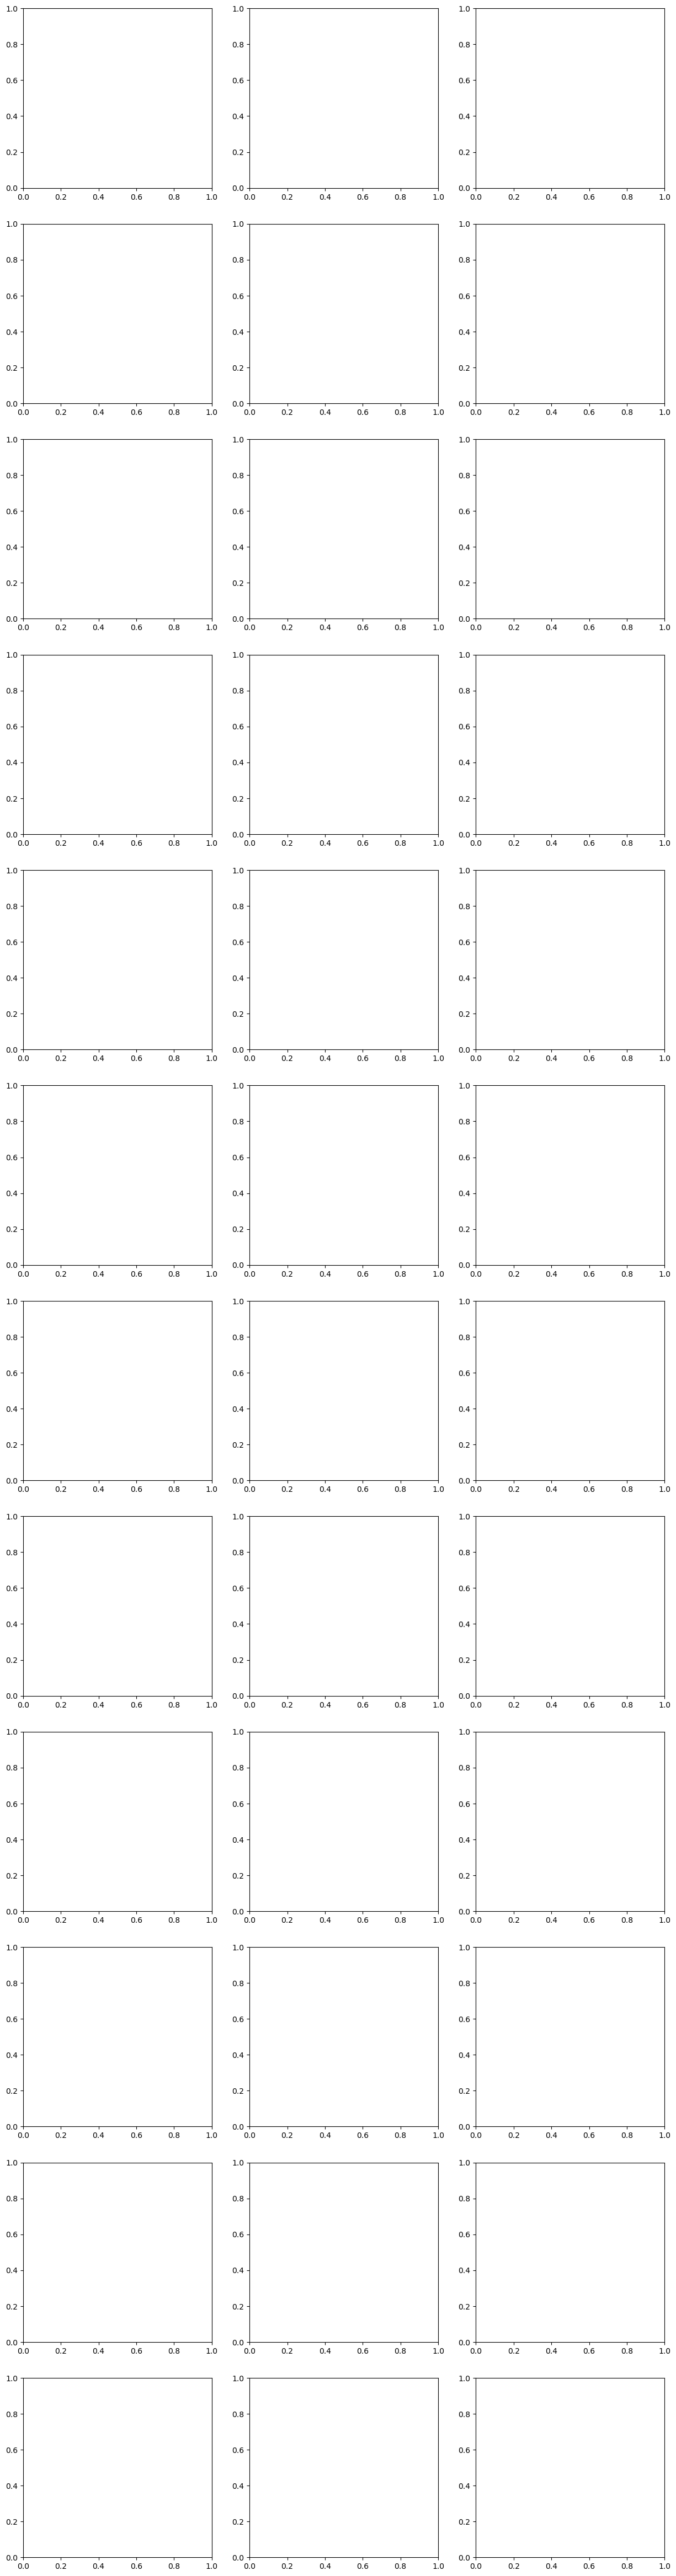

In [15]:
method_list=[
    'init',
  'CPD',
'OT-RBF',
'OT-TPS', 
'SOT-RBF',
'SOT-TPS',
 'TPS-RPM',
 'TPS-RPM-new',
  'OPT-RBF',
  'OPT-TPS',
   'SOPT-RBF',
   'SOPT-TPS'
]


import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# List of PNG file paths.
# Replace this with the paths to your own images.


# Number of rows and columns
rows = len(method_list)
cols = len(label_list)



# Index for iterating over filepaths
index = 0

# Iterate over each subplot and display the image

for eta in [0.05,0.10]:
    
    # Create a figure
    fig, axs = plt.subplots(rows, cols, figsize=(3*5, 12*5))
    # Remove the gaps between subplots

    
    for (j,label) in enumerate(label_list):
        save_path='results/3D_%s_%0.2f/'%(label,eta)
        for (i,method) in enumerate(method_list):
            # print('method here',method)
            if i in [0]:
                path=save_path+'pic/init.jpg'
            else:
                path=save_path+'pic/'+method+'_final.jpg'
            img = mpimg.imread(path)
            img_crop=img[60:-60,:,:]
            axs[i, j].imshow(img_crop)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            # axs[i, j].axis('off')  # Hide axes
            if j==0:
                #print('method here2',method)
                #print('i is',i)
                if method=='TPS-RPM-new':
                    method_name='TPS-RPM(new)'
                else:
                    method_name=method
                axs[i, j].set_ylabel(method_name,fontsize=30)
            
#     for (i,method) in enumerate(method_list):
#         fig.text(0.1 + (i * 0.1), 0.05, method, ha='center')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(wspace=0, hspace=-0.5)
    plt.savefig('results/3D_%0.2f.pdf'%eta, bbox_inches='tight', pad_inches=0)
    # Display the figure
    plt.show()

In [65]:
method_list

{'CPD',
 'OPT-RBF',
 'OPT-TPS',
 'OT-RBF',
 'OT-TPS',
 'SOPT-RBF',
 'SOPT-TPS',
 'SOT-RBF',
 'SOT-TPS',
 'TPS_RPM',
 'TPS_RPM_new',
 'init'}

In [4]:
#@nb.njit(cache=True)
def correspondence_sopt(X,Y,projections,Lambda_list):
    N,d=projections.shape
    n=X.shape[0]
    Lx_org=arange(0,n)
    for i in range(N):
        theta=projections[i]
        X_theta=np.dot(theta,X.T)
        Y_theta=np.dot(theta,Y.T)
        X_indice=X_theta.argsort()
        Y_indice=Y_theta.argsort()
        X_s=X_theta[X_indice]
        Y_s=Y_theta[Y_indice]
        Lambda=Lambda_list[i]
        obj,phi,psi,piRow,piCol=opt1d(X_s,Y_s,Lambda)
#        Cost,L=o(X_s,Y_s,Lambda)
        
        L=piRow
        L=recover_indice(X_indice,Y_indice,L)
        #move X
        Lx=Lx_org.copy()
        Lx=Lx[L>=0]
        if Lx.shape[0]>=1:
            Ly=L[L>=0]
#            dim=Ly.shape[0]
            X_take=X_theta[Lx]
            Y_take=Y_theta[Ly]
            X[Lx]+=np.expand_dims(Y_take-X_take,1)*theta
    return X

In [48]:
@nb.njit(cache=True)
def gradient_flow_sot(X,Y,projections):
    n_proj,d=projections.shape
    N=X.shape[0]
    for i in range(n_proj):
        theta=projections[i]
        X_theta,Y_theta=np.dot(theta,X.T),np.dot(theta,Y.T)
        sorter_X,sorter_Y=X_theta.argsort(),Y_theta.argsort()
        X_s,Y_s=X_theta[sorter_X],Y_theta[sorter_Y]
        #move X
        displacement_s=Y_s-X_s
        inv_sorter_X=permutation_inverse(sorter_X)
        X+=np.expand_dims(displacement,1)*theta
    Domain=arange(0,N)
    return X,Domain

@nb.njit(cache=True)
def gradient_flow_sopt(X,Y,projections,Lambda=1.0,Lambda_step=0.1,Lambda_lb=0.001,N0=4):
    (n_proj,d),N=projections.shape,X.shape[0]
    Domain=np.full(N,False)
    for i in range(n_proj):
        theta=projections[i]
        X_theta,Y_theta=np.dot(theta,X.T),np.dot(theta,Y.T)
        sorter_X,sorter_Y=X_theta.argsort(),Y_theta.argsort()
        X_s,Y_s=X_theta[sorter_X],Y_theta[sorter_Y]
        obj,phi,psi,piRow,piCol=opt1d(X_s,Y_s,Lambda)
            
        #move X        
        displacement_s=np.zeros(N)
        Domain_s=piRow>=0
        Range_s=piRow[Domain_s]
        displacement_s[Domain_s]=Y_s[Range_s]-X_s[Domain_s]
        inv_sorter_X=permutation_inverse(sorter_X)
        displacement,Domain_theta=displacement_s[inv_sorter_X],Domain_s[inv_sorter_X]
        X+=np.expand_dims(displacement,1)*theta
        
        #update domain 
        # if test 
            # L=recover_indice(sorter_X,sorter_Y,piRow)
            # Domain_theta2=L>=0
            # print('domain1',Domain_theta)
            # print('domain2',Domain_theta2)
        Domain+=np.logical_or(Domain,Domain_theta)
        
        # update Lambda
        mass=np.sum(Domain_s)
        mass_diff_relative=(mass-N0)/N0
        Lambda,Lambda_step=update_lambda(Lambda,Lambda_step,mass_diff_relative,Lambda_lb)
    return X,Domain,Lambda,Lambda_step
    
    


In [49]:
Yhat=np.random.rand(5,3)
Y=Yhat.copy()+0.2
Y[0]+=1000
N,D=Yhat.shape
projections=random_projections(D,corr['n_proj']-90,1)
Lambda=5.0
Yhat2,Domain,_,_=gradient_flow_sopt(Yhat.copy(),Y,projections,Lambda=Lambda,Lambda_step=1/8*Lambda)
Yhat3=correspondence_sopt(Yhat.copy(),Y,projections,np.full(corr['n_proj']-90,5.0))


In [7]:
def gradient_flow_sot(corr,Yhat,Y):
    N,D=Yhat.shape
    projections=random_projections(D,corr['n_proj'],1)
    Domain=np.full(N,False)
    for (epoch2,theta) in enumerate(projections):
        Yhat_theta,Y_theta=np.dot(theta,Yhat.T),np.dot(theta,Y.T)
        Yhat_indice,Y_indice=Yhat_theta.argsort(),Y_theta.argsort()
        Yhat_s,Y_s=Yhat_theta[Yhat_indice],Y_theta[Y_indice]
        if corr['name']=='sot':
            piRow=arange(0,N)
        elif corr['name']=='sopt':
            obj,phi,psi,piRow,piCol=opt1d(Yhat_s,Y_s,corr['Lambda'])              
        L=recover_indice(Yhat_indice,Y_indice,piRow)
        Domain_theta,Range=L>=0,L[L>=0]
        Yhat[Domain_theta]+=np.expand_dims(
            Y_theta[Range]-Yhat_theta[Domain_theta],1)*theta
        Domain=np.logical_or(Domain,Domain_theta)
        if corr['name']=='sopt':
            mass=np.sum(Domain)
            mass_diff=mass-corr['N0']
            corr['Lambda'],corr['Lambda_step']=update_lambda(
                corr['Lambda'],corr['Lambda_step'],
                mass_diff,corr['N0'],corr['Lambda_lb'])
        return Yhat,Domain

work?


In [8]:
def permutation_inverse(permutation):
    N=permutation.shape[0]
    Domain=np.arange(N)
    mapping=np.stack((Domain,permutation))
    mapping_final=mapping[0].take(mapping[1].argsort())
    return mapping_final
    
X=np.random.rand(3)
sorter_X=X.argsort()
X_s=X[sorter_X]
sorter_X_inv=permutation_inverse(sorter_X)
print(X_s[sorter_X_inv])



[0.86301261 0.78704642 0.23808531]


results/3D_neutral_2_29_0.05/


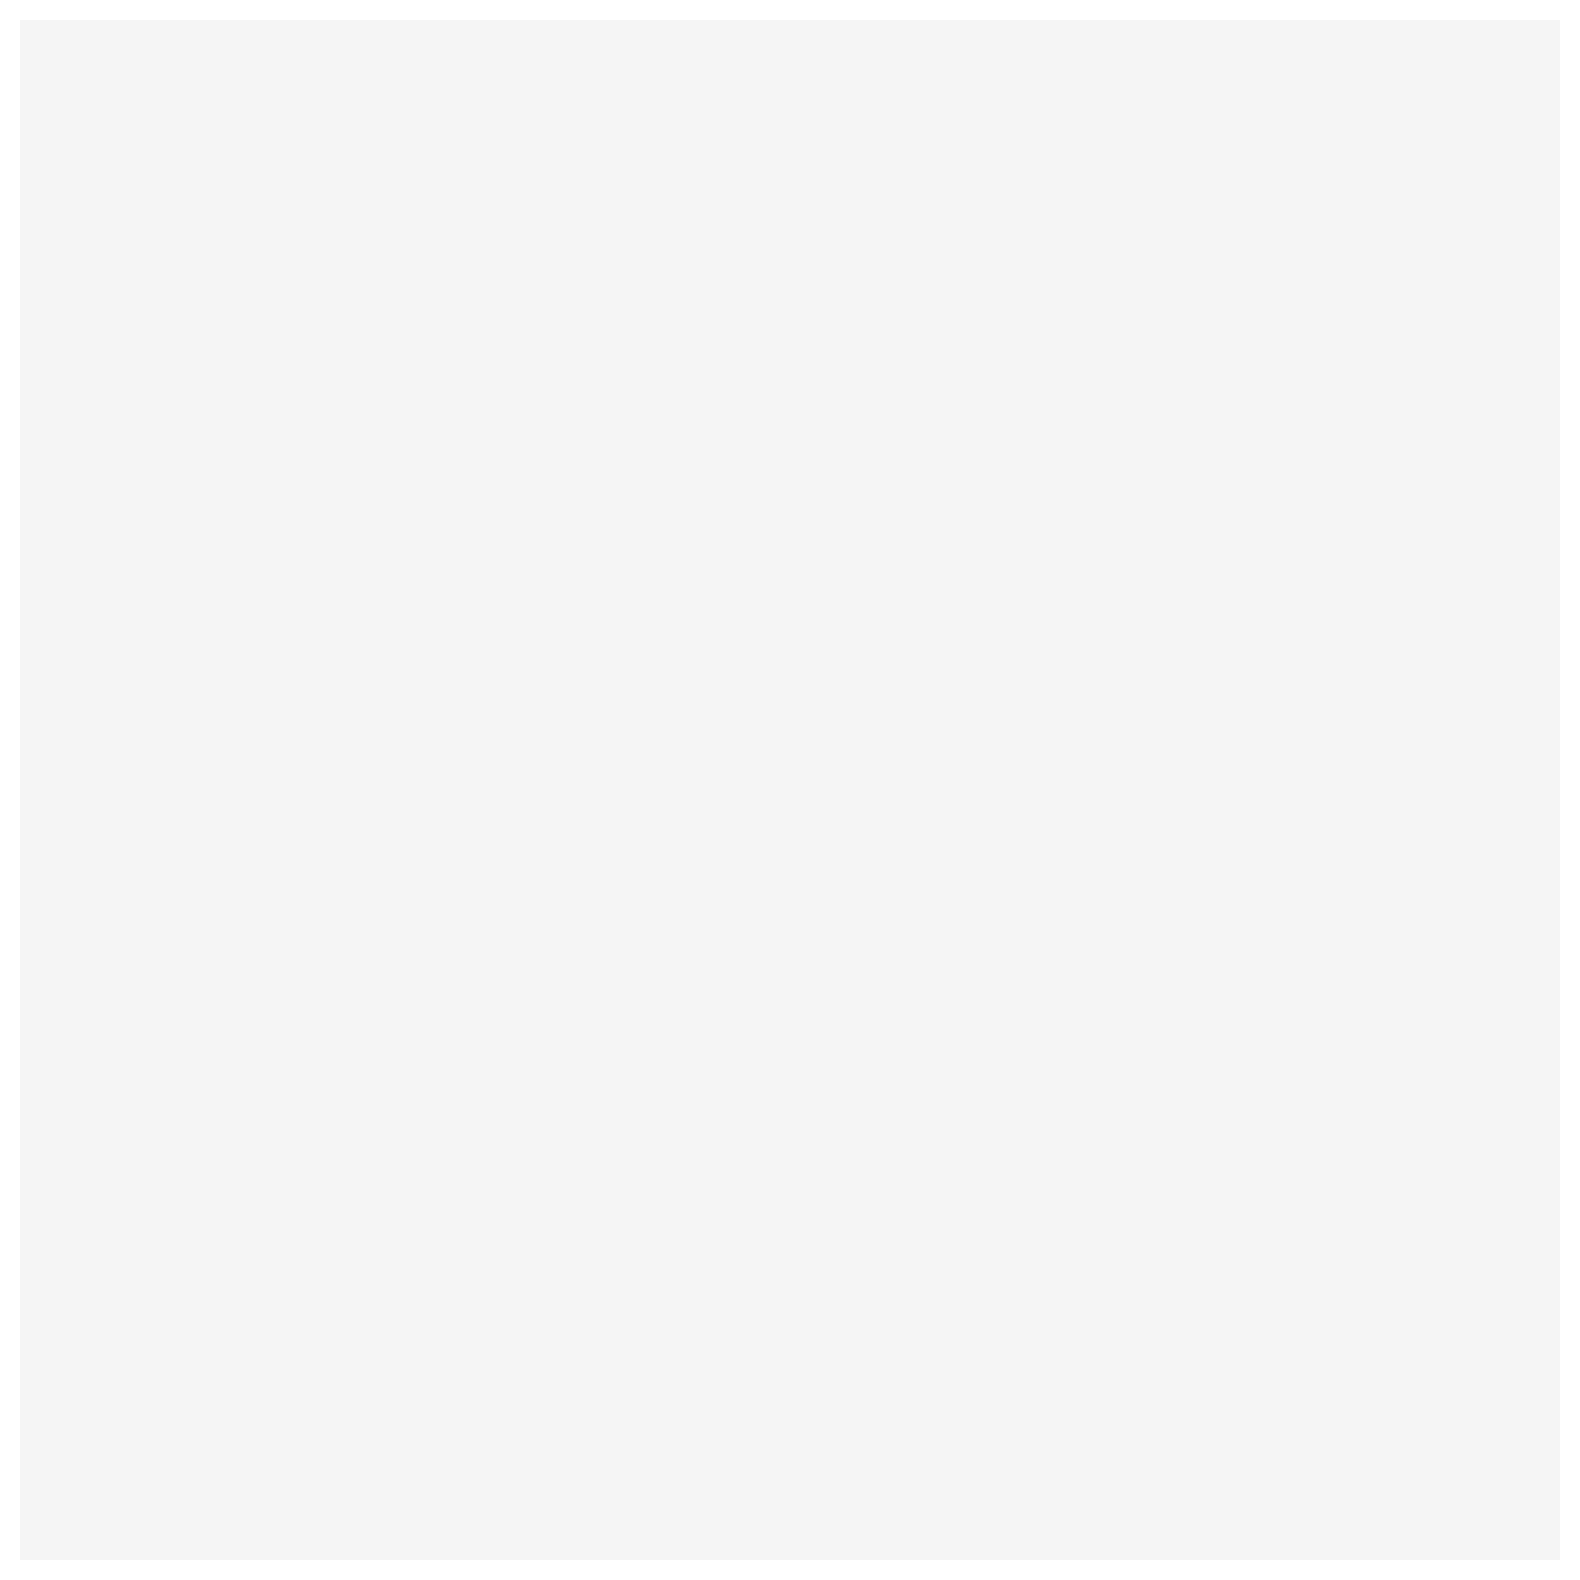

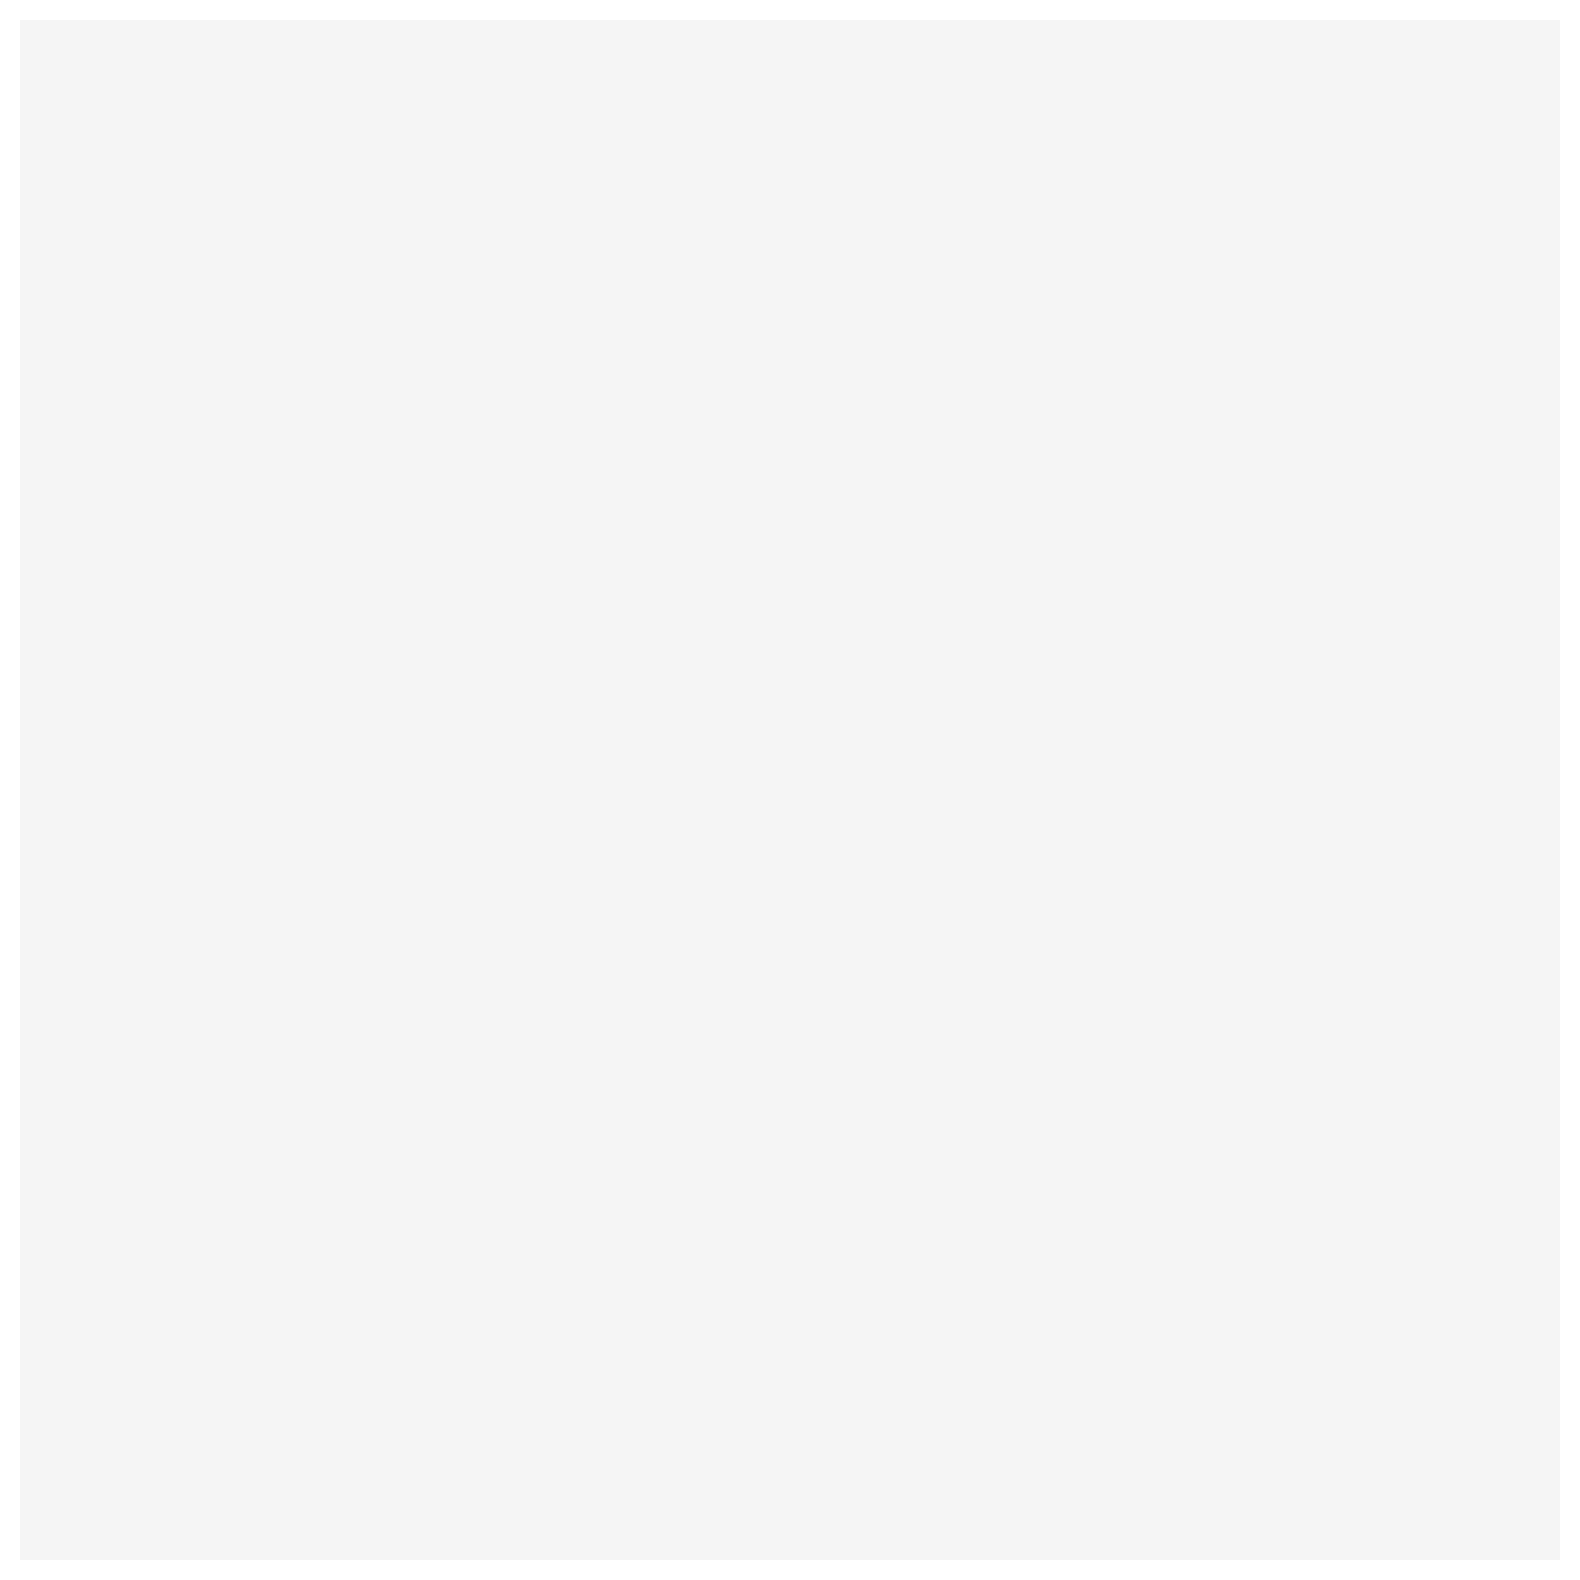

last error is 221.0457494110317


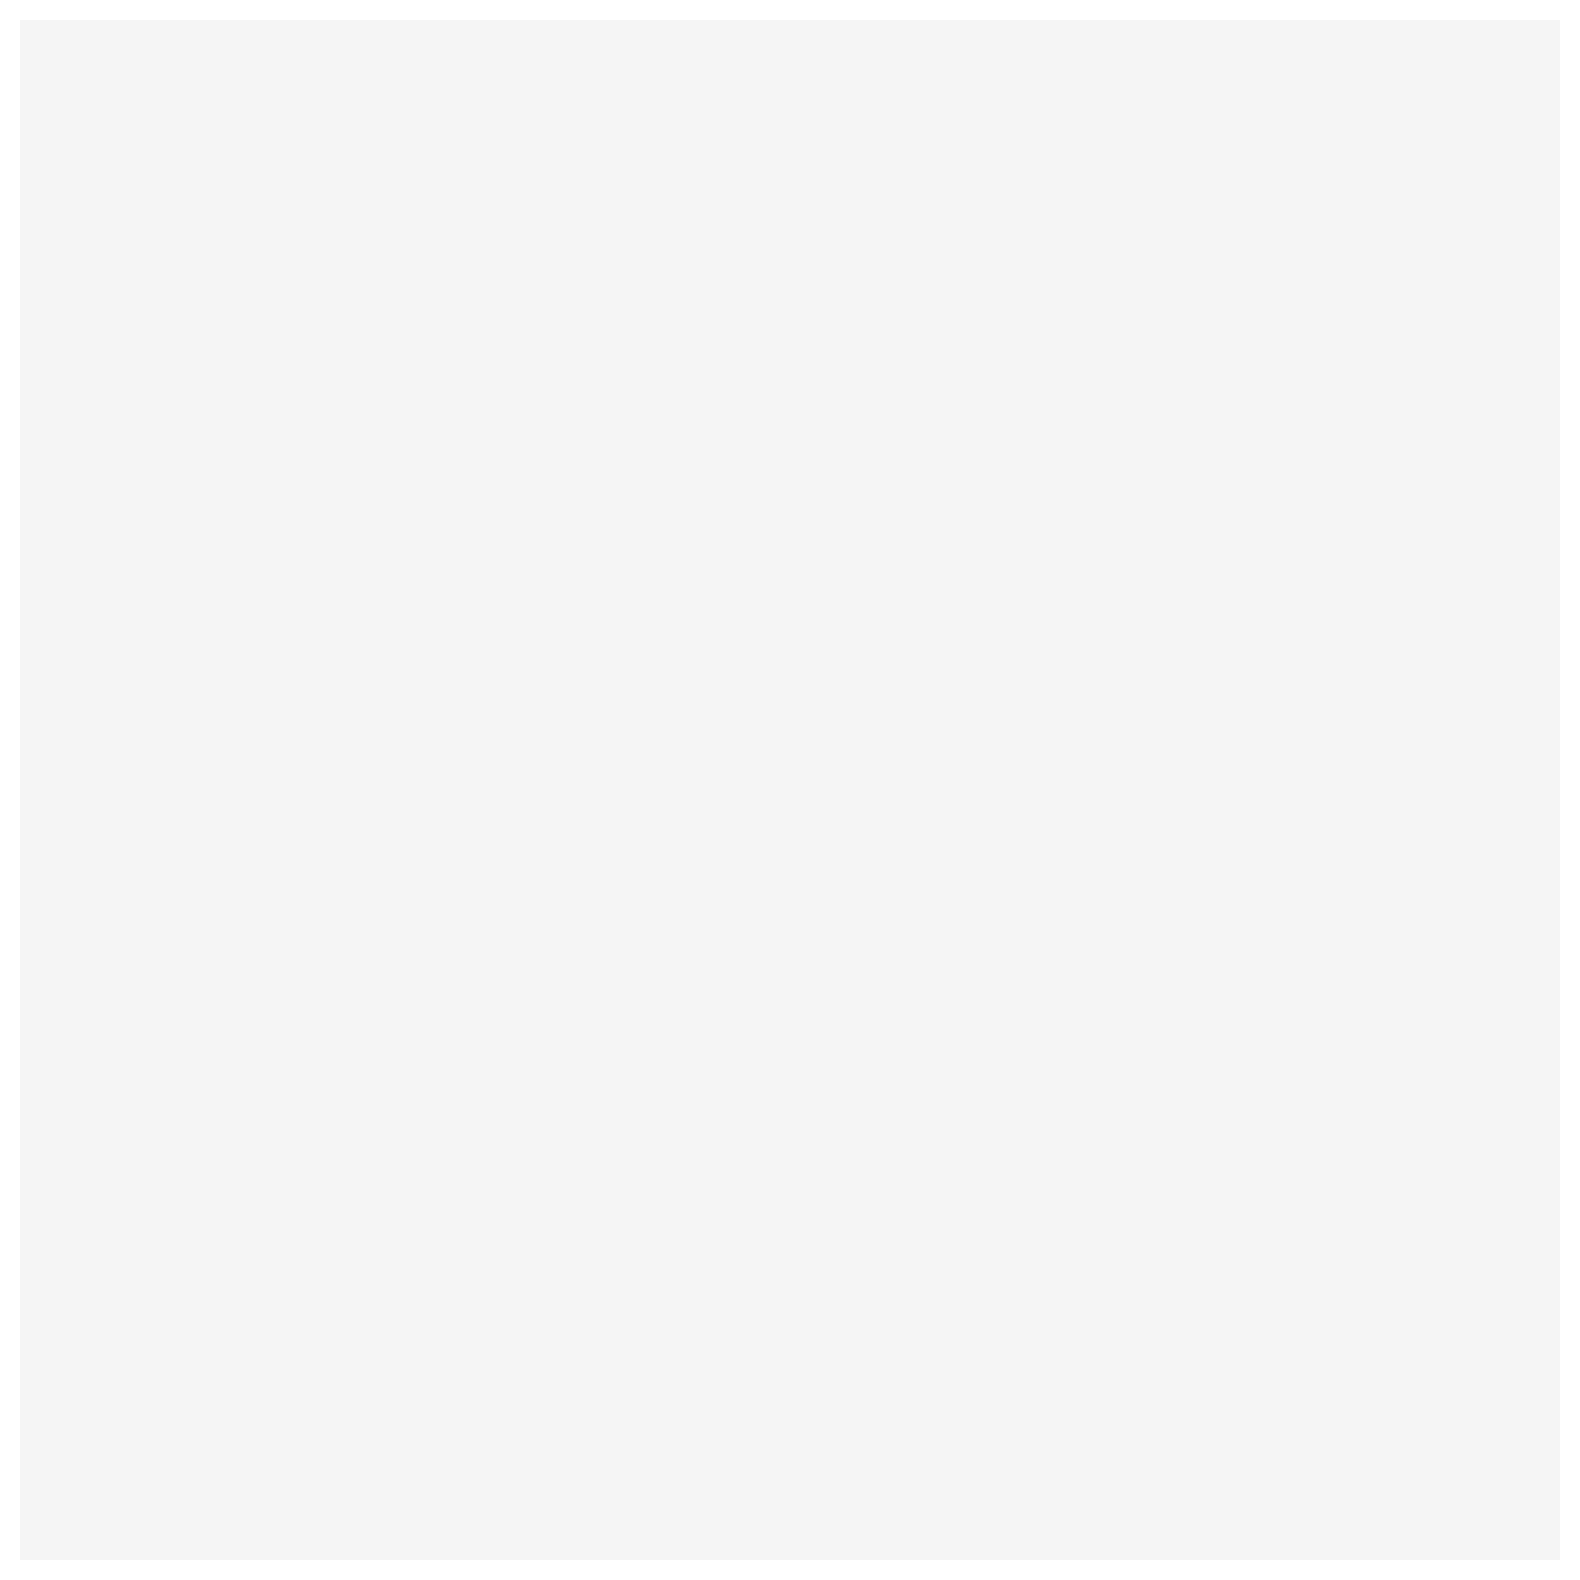

last error is 221.0457494110317
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [19]:
method_list=[
    'init',
   'CPD',
   'OT-RBF',
   'OT-TPS', 
   'SOT-RBF',
   'SOT-TPS',
   'TPS_RPM',
   'TPS_RPM(new)',
   'OPT-RBF',
   'OPT-TPS',
    'SOPT-RBF',
    'SOPT-TPS'
]

data=torch.load('data/%s.pt'%(label))
eta_list=[0.05,0.10]
eta=0.05
method='OT-RBF'
save_path='results/3D_%s_%0.2f/'%(label,eta)
print(save_path)
X0=data['X0']
N0=X0.shape[0]
X=data['X'+str(eta)]
Y=data['Y'+str(eta)]
permutation=data['permutation'+str(eta)]

model,Yhat_list,record_idx,runing_time=torch.load(save_path+'%s.pt'%(method))
make_plot(Yhat_list[-1],Yhat_list[-1],N0)
Yhat_list1=model_to_Yhat(model,X,method)
error1=compute_error(X,Y,N0,model=model,Yhat_list=None,permutation=permutation,method=method)
error2=compute_error(X,Y,N0,model=None,Yhat_list=Yhat_list,permutation=permutation,method=method)
for (err1,err2) in zip(error1,error2):
    print(err1-err2)

results/3D_neutral_2_29_0.05/
method is SOPT-RBF, record_index is [ 0 19]
last error is nan
<<<<<<<<<<method SOPT-RBF


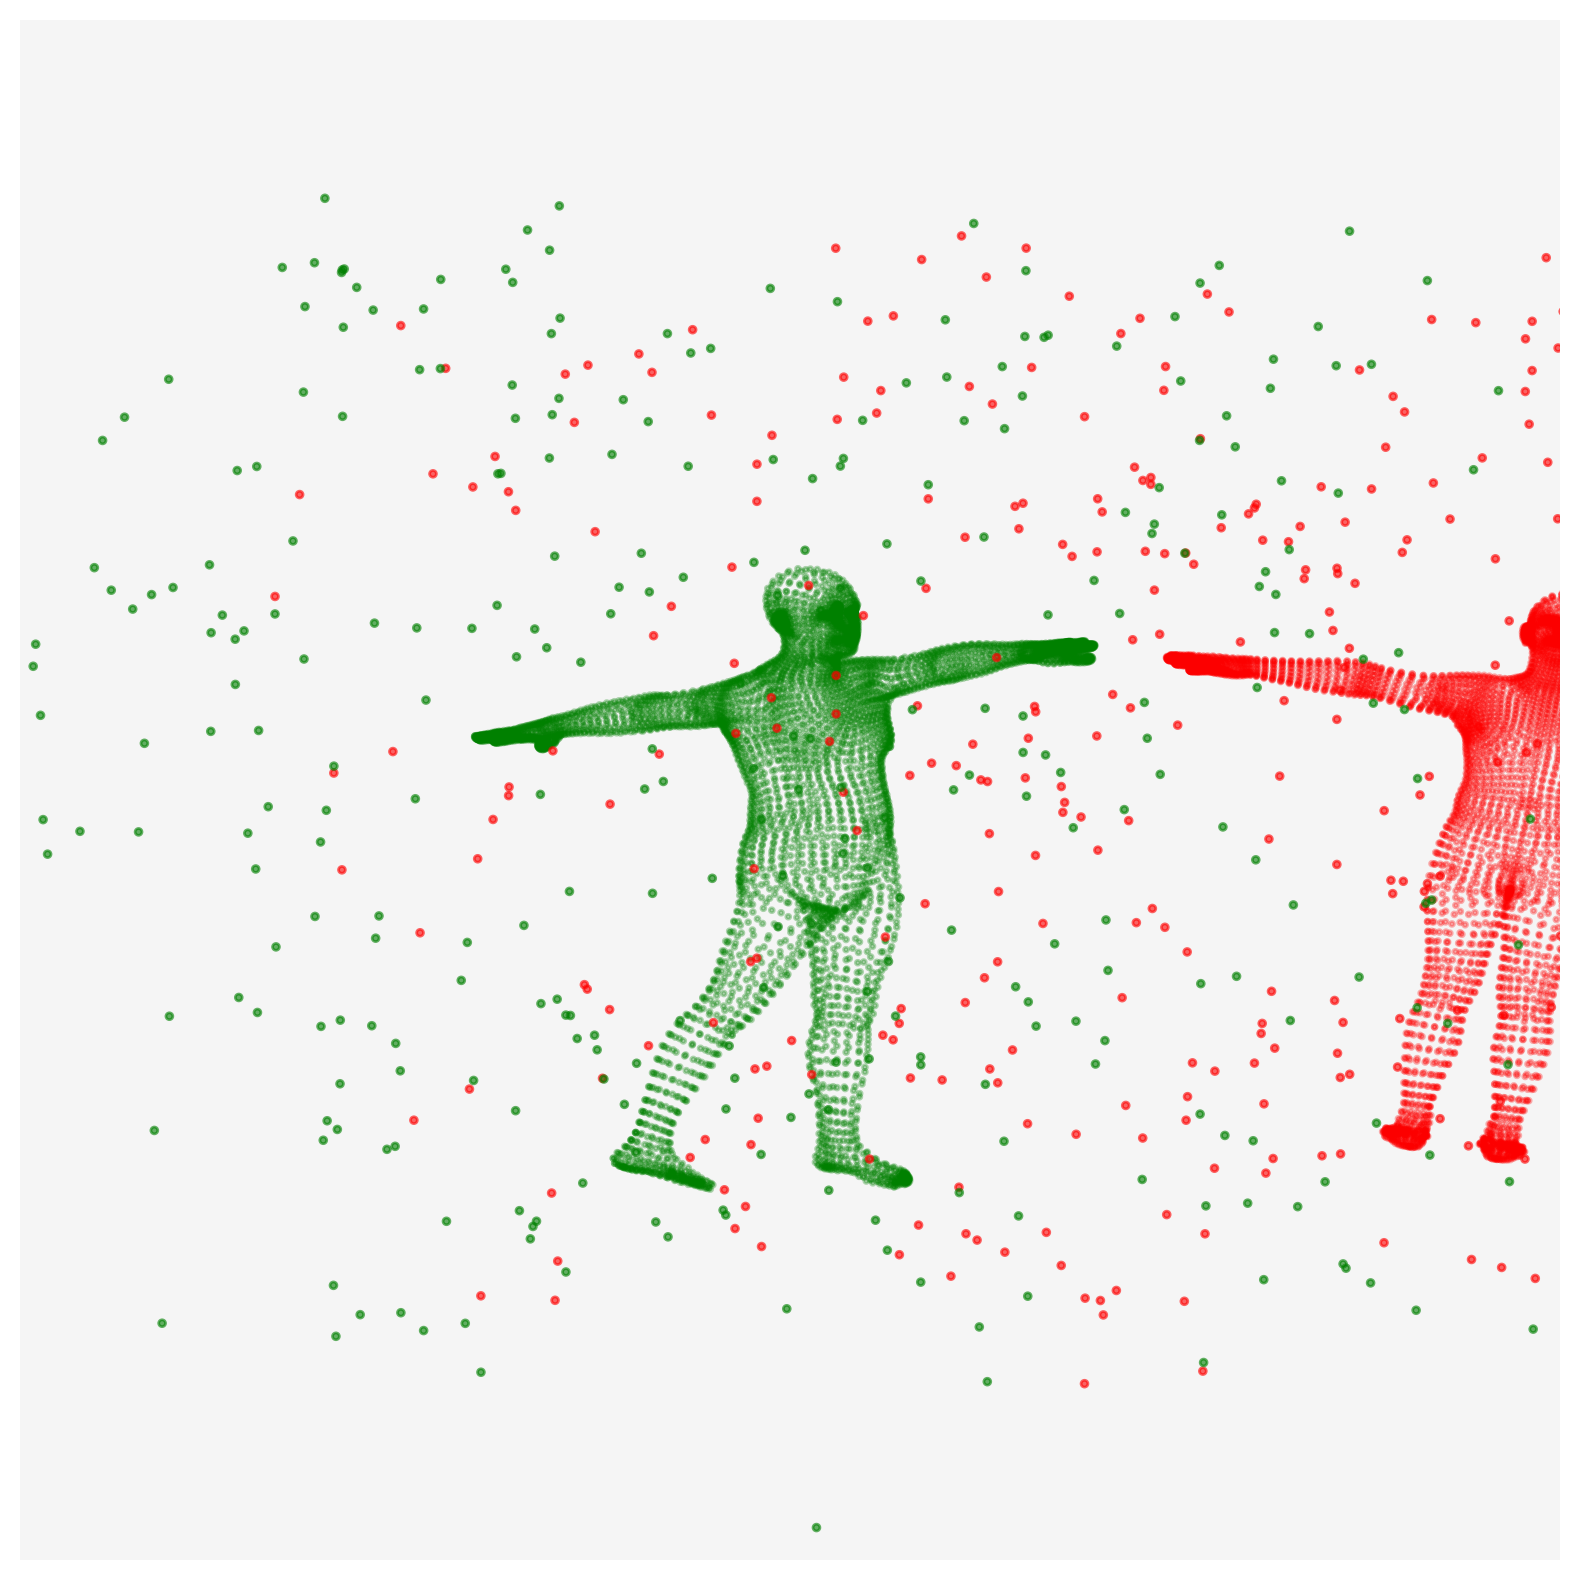

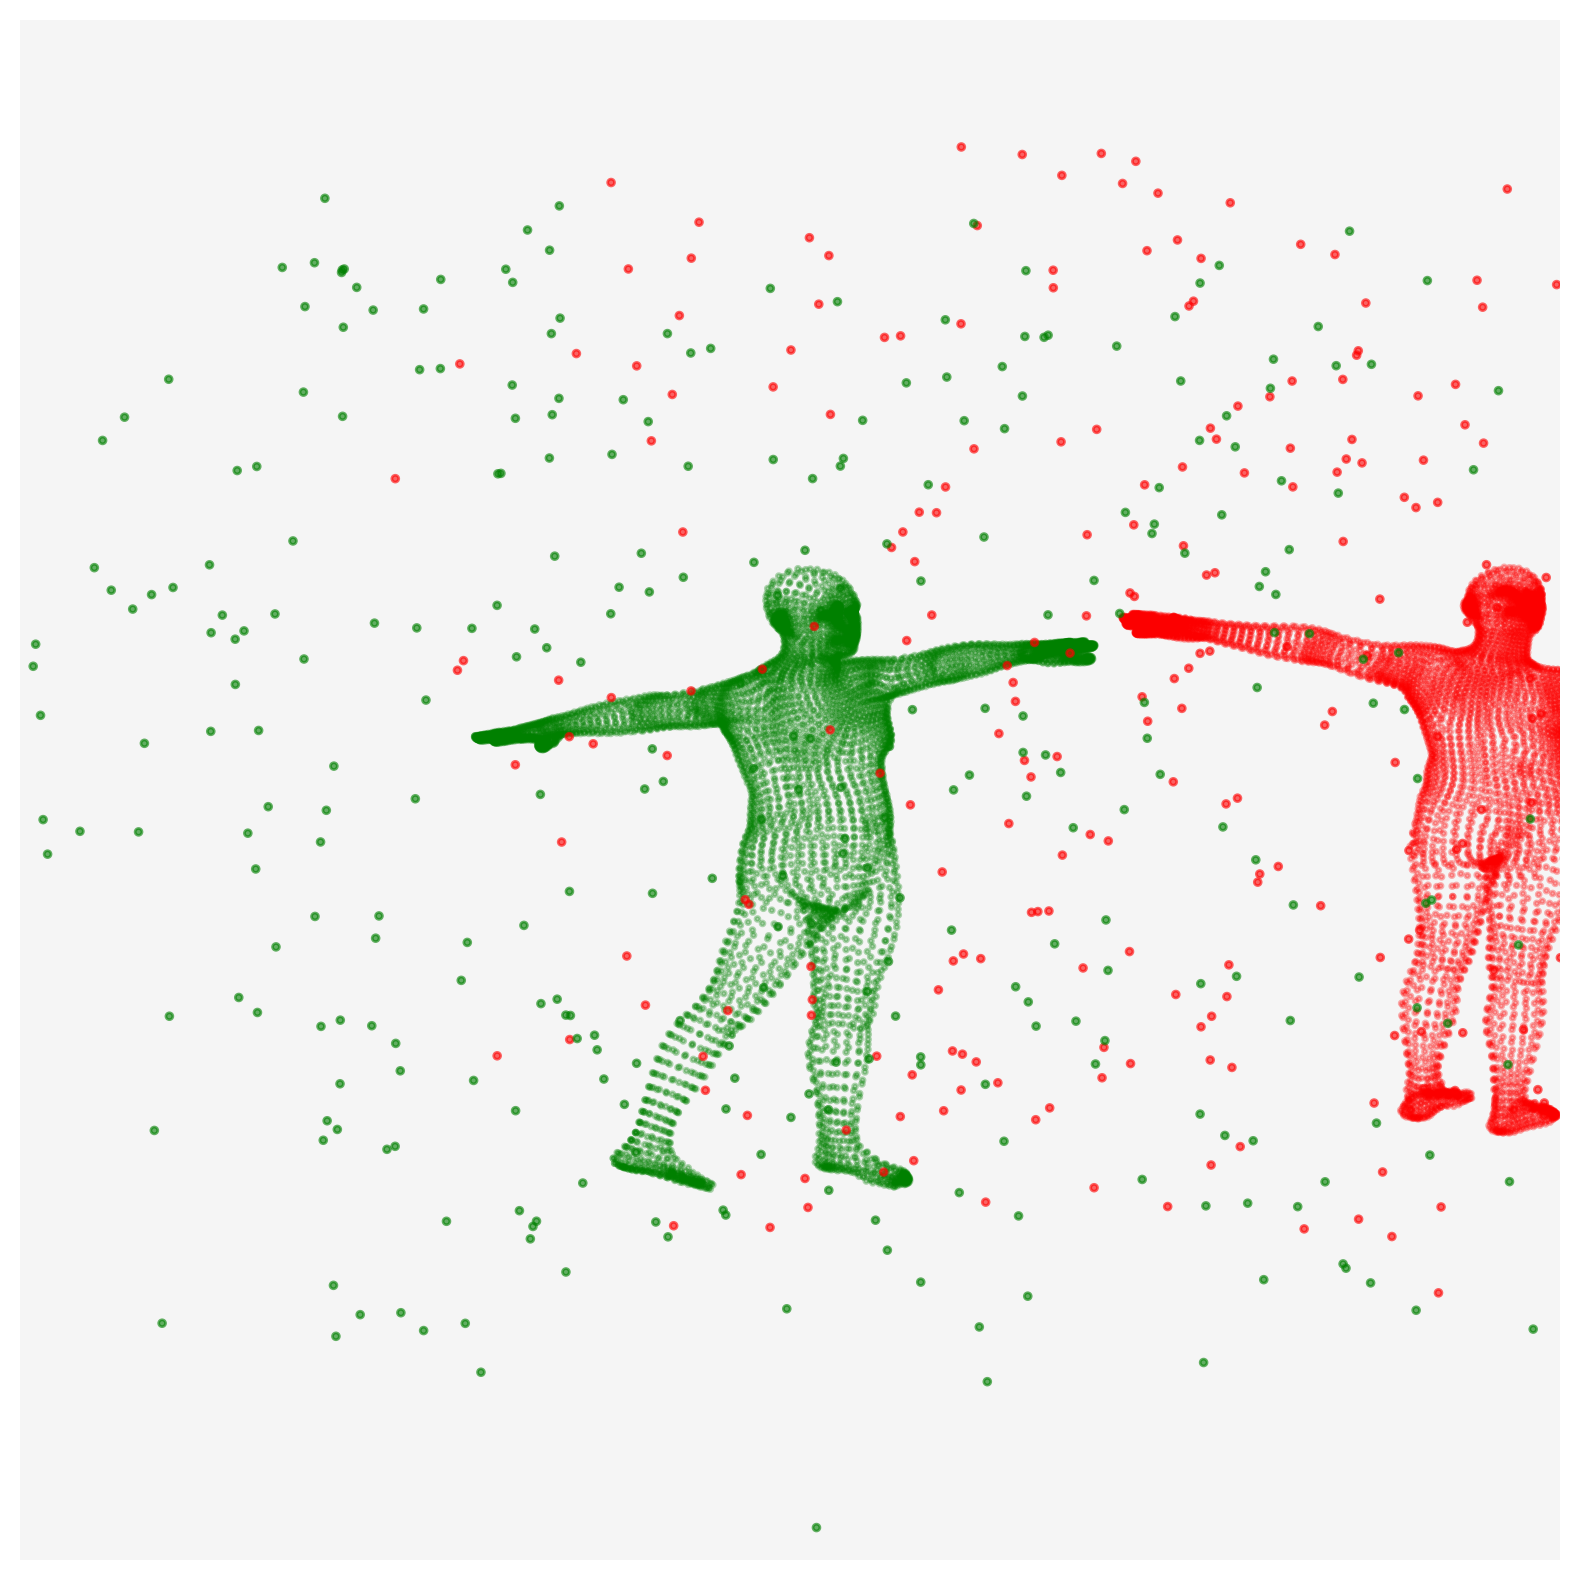

<<<<<<<end<<<<<<<<<<<<
method is SOPT-TPS, record_index is [ 0 19]
last error is 119.61682717926719
<<<<<<<<<<method SOPT-TPS


KeyboardInterrupt: 

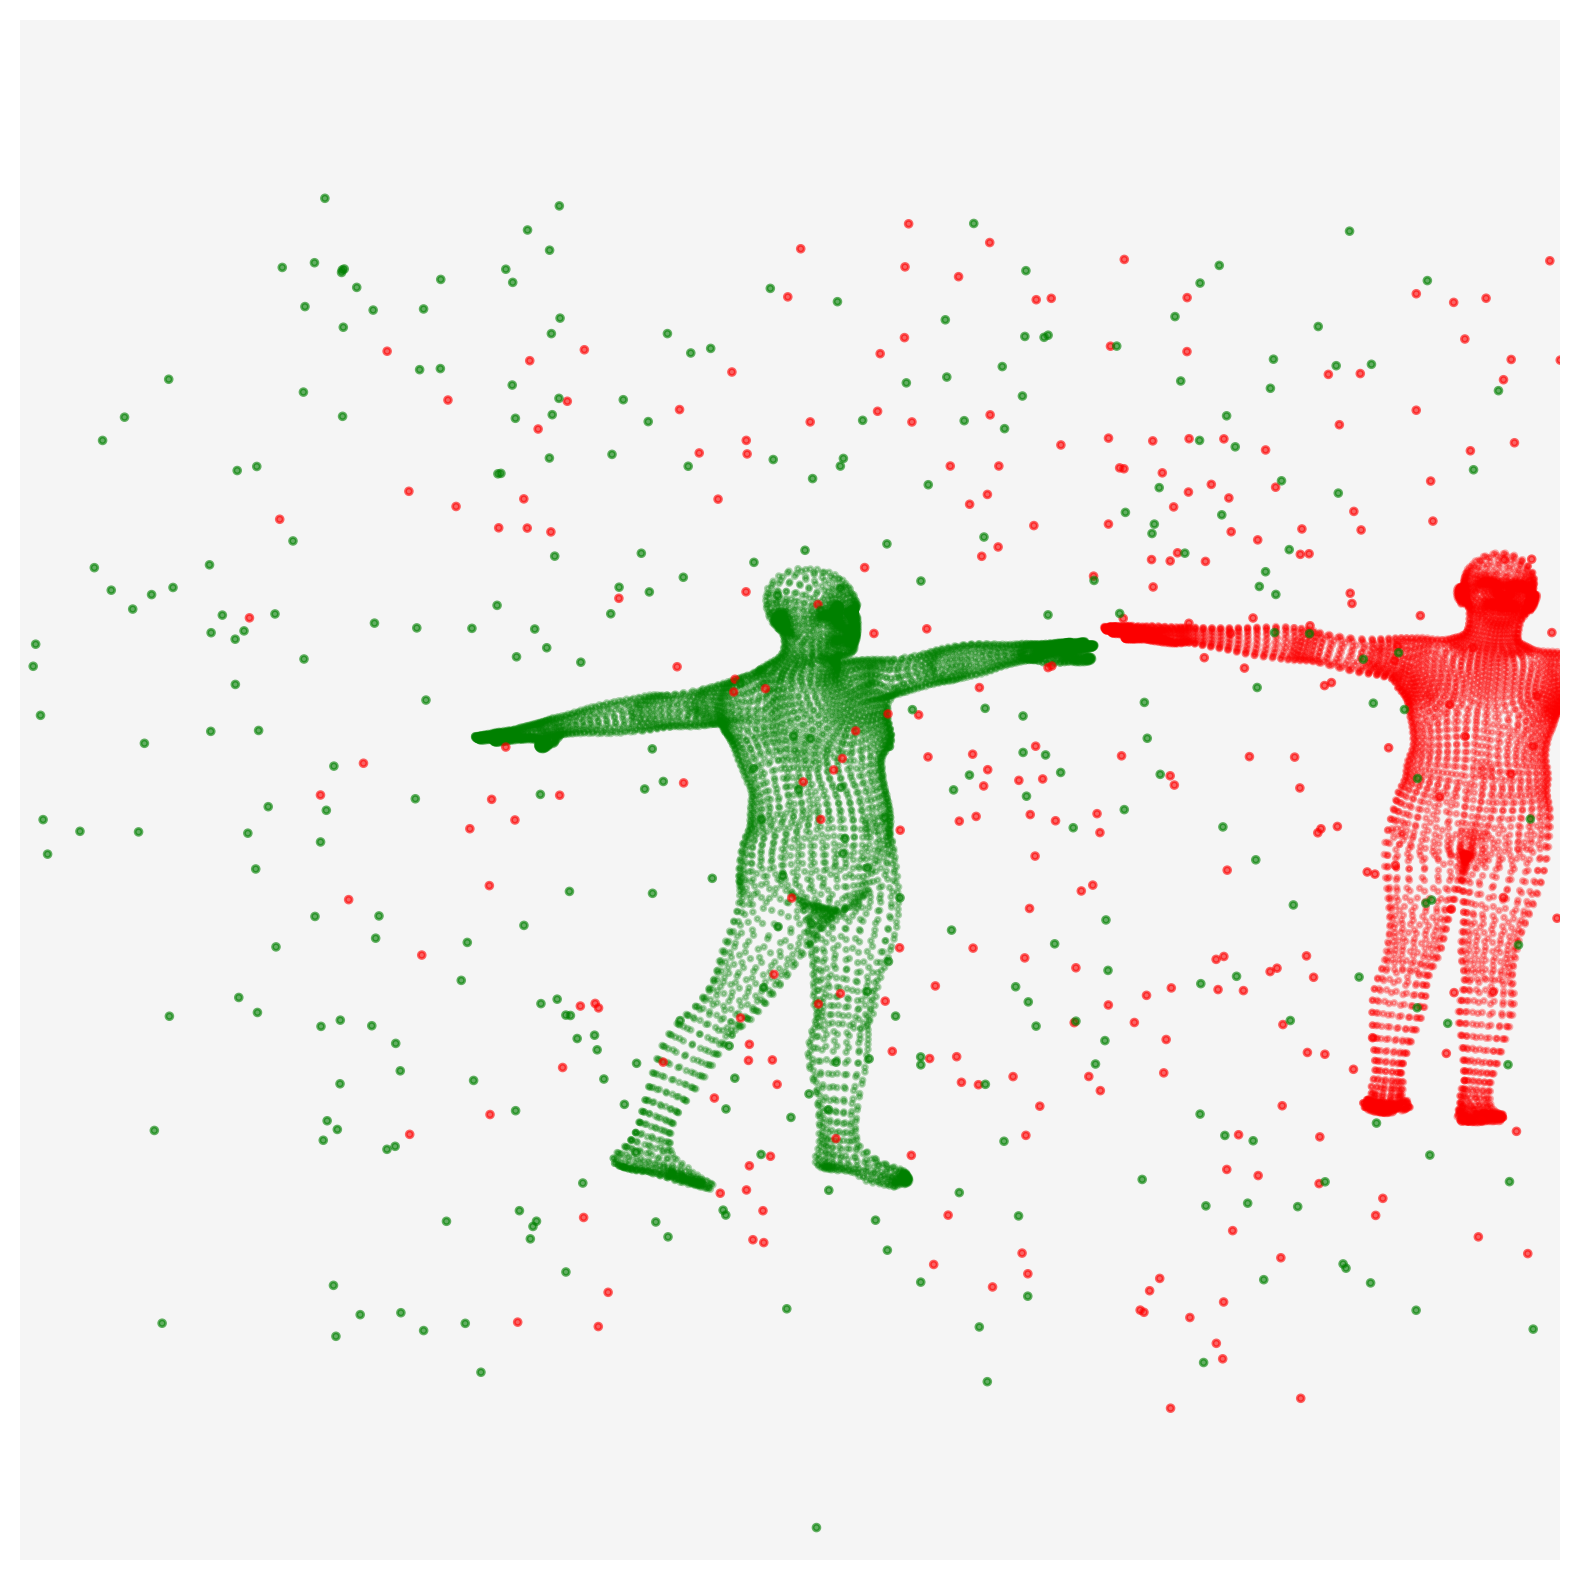

In [36]:
for eta in [0.05]:
    save_path='results/3D_%s_%0.2f/'%(label,eta)
    print(save_path)
    X0=data['X0']
    N0=X0.shape[0]
    permutation=data['permutation%s'%eta]
    X=data['X'+str(eta)]
    Y=data['Y'+str(eta)]
    for method in method_list[1:]:
        model,Yhat_list,record_idx,runing_time=torch.load(save_path+'%s.pt'%(method))
        print('method is %s, record_idx is %s'%(method,record_idx))
        error_list=compute_error(X=X,Y=Y,N0=N0,model=model,permutation=permutation,method=method)
        torch.save((record_idx,error_list),save_path+'%s_error.pt'%(method))
        
        print('<<<<<<<<<<method %s'%method)
        Yhat_list=model_to_Yhat(model,X,method)
        path=save_path+'pic/'+method
        visual_3D(Yhat_list,Y,N0,path,record_idx)
        print('<<<<<<<end<<<<<<<<<<<<')


